In [ ]:
# Load dataset "compilado_delitos_2022.xlsx" with pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Read the data, all strings
df_copy = pd.read_excel('compilado_delitos_2022.xlsx', dtype=str)

In [ ]:
df = df_copy.copy()
#Print dimensions of the dataset
print(df.shape)# Print columns of the dataset
print(df.columns)
# Print the first 5 rows of the data
# df.head()

In [ ]:
''' Save columns and drop the ones that are not needed
       ['fecha_creacion', 'hora_creacion',
       'dia_semana', 'incidente_c4', 'colonia', 'delegacion_inicio',
       'sector_inicio', 'latitud', 'longitud']
'''
# solo considerar los registros que tengan "A" en la columna codigo_cierre
df = df[df['codigo_cierre'] == 'A']

# Remove YYYY-MM-DD in field hora_creacion
df['hora_creacion'] = df['hora_creacion'].str[11:13]+':00'
# Remove rows with date 2021-12-31
df = df[df.fecha_creacion != '2021-12-31']
df = df[df.fecha_creacion != '2023-01-01']
# Remove YYYY of field fecha_creacion
df['fecha_creacion'] = df['fecha_creacion'].str[5:]
# Map dia_semana from name to int-name
df['dia_semana'] = df['dia_semana'].replace({'Lunes':'1-Lunes', 'Martes':'2-Martes', 'Miércoles':'3-Miércoles', 'Jueves':'4-Jueves', 'Viernes':'5-Viernes', 'Sábado':'6-Sábado', 'Domingo':'7-Domingo'})
# Map mes_creacion from name to int-name
df['mes_creacion'] = df['fecha_creacion'].str[:2].replace({'01':'01-Enero', '02':'02-Febrero', '03':'03-Marzo', '04':'04-Abril', '05':'05-Mayo', '06':'06-Junio', '07':'07-Julio', '08':'08-Agosto', '09':'09-Septiembre', '10':'10-Octubre', '11':'11-Noviembre', '12':'12-Diciembre'})
# Map dia-mes_creacion from name to int
df['dia_creacion'] = df['fecha_creacion'].str[3:]
# Get de week number of the year
df['semana_creacion'] = pd.to_datetime(df['fecha_creacion'], format='%m-%d').dt.week


columns = ['fecha_creacion', 'hora_creacion', 'mes_creacion', 'dia_creacion', 'semana_creacion',
        'dia_semana', 'incidente_c4', 'colonia', 'delegacion_inicio',
        'sector_inicio', 'latitud', 'longitud', 'codigo_cierre']

df = df[columns]



# Print the first 5 rows of the data
df.head()

In [ ]:
# diferentes codigo_cierre en el dataset
df.codigo_cierre.unique()

In [ ]:
#cuantos registros hay de cada codigo_cierre
df.codigo_cierre.value_counts()


In [ ]:
# Separar los datos por delitos
df_delitos = df.groupby('incidente_c4')
# df_delitos.head()

In [ ]:
# 'Estadisticas trimestrales' en ingles: 'Trimestral statistics'
def statistic_frequency(df_main:pd.DataFrame, conditionals:list[pd.Series], groupby:str, titles:list[str], dir:str, num_high:int=5, num_low:int=5):
	from matplotlib.backends.backend_pdf import PdfPages
	import os

	if not os.path.exists(dir):
		os.makedirs(dir)

	with PdfPages(dir + '/'+ dir +'.pdf') as pdf:
		df_main_by_delitos = df_main.groupby('incidente_c4')
		for delito, delito_df in df_main_by_delitos:
			fig, axes = plt.subplots(nrows=1, ncols=len(conditionals), figsize=(5*len(conditionals), 5))
			# check if axes is a list or a single axis
			if not isinstance(axes, np.ndarray):
				axes = [axes]

			df_delito_pts = [delito_df[conditional] for conditional in conditionals]
			
			
			for df_section,title,axe in zip(df_delito_pts, titles, axes):
				delito_df_pt = df_section.groupby(groupby).count()['incidente_c4']
		
				delito_df_pt.plot(ax=axe, color='black', alpha=0.25)
				axe.set_title(title)
				axe.set_xticklabels(axe.get_xticklabels(), rotation=90)

				# Add scatter points with text labels to 5th hights days
				delito_df_pt1_sorted = delito_df_pt.sort_values(ascending=False)
				for i, (x, y) in enumerate(zip(delito_df_pt1_sorted.index, delito_df_pt1_sorted.values)):
					if i < num_low or i+num_high >= len(delito_df_pt1_sorted):
						x_pos = delito_df_pt.index.get_loc(x)
						axe.scatter(x_pos, y, s=10,  color='red' if i<num_low else 'green')
						axe.text(x_pos, y, str(f"{x} [{y}]"), fontsize=8, color='red' if i<num_low else 'green', rotation=90,  horizontalalignment='right', verticalalignment='top')

			#Get Max scale of all axes using get_ylim()
			y_max = max([ax.get_ylim()[1] for ax in axes])
			#Set all axes to the same scale
			for ax in axes:
				ax.set_ylim(0, y_max)


			plt.suptitle(delito)
			plt.savefig(f"{dir}/{delito}.png")
			pdf.savefig()
			plt.show()
		plt.close()

def statistic_heatmap(df_main:pd.DataFrame, index, columns, title, dir:str):
	import os
	import seaborn as sns
	import matplotlib.pyplot as plt
	from matplotlib.backends.backend_pdf import PdfPages

	if not os.path.exists(dir):
		os.makedirs(dir)


	with PdfPages(f'{dir}/{dir}.pdf') as pdf:
		df_main_by_delitos = df_main.groupby('incidente_c4')
		for delito, delito_df in df_main_by_delitos:
			# Create a pivot table with the count of incidents by day and hour
			delito_df_pt = delito_df.pivot_table(index=index, columns=columns, values='incidente_c4', aggfunc='count', fill_value=0)
			# Plot the heatmap
			fig, ax = plt.subplots()
			sns.heatmap(delito_df_pt, cmap='Spectral_r', annot=True, ax=ax, fmt='d')
			# plt.tick_params(axis='x', labelrotation=90, labeltop=True, labelbottom=False, labelsize=20)
			ax.set_title(title)
			plt.suptitle(delito)
			pdf.savefig()
			plt.savefig(f"{dir}/{delito}.png")
			plt.show()
		plt.close()

def statistic_geomap(df_main:pd.DataFrame, groupby:str, title:str, dir:str, USE_SECTORS:bool=True):
	import os
	import geopandas as gpd
	from shapely.geometry import Point
	from matplotlib.backends.backend_pdf import PdfPages
	import matplotlib.pyplot as plt
	import seaborn as sns

	if not os.path.exists(dir):
		os.makedirs(dir)

	if USE_SECTORS:
		mxcity = gpd.read_file('mapa_mexico_sectores/')\
			.set_index('TERRITORIA')\
			.to_crs(epsg=4326)
	else:
		# Obtain the map of Mexico
		mx = gpd.read_file('mapa_mexico/')\
				.set_index('CLAVE')\
				.to_crs(epsg=4326)
		# obtain the map of Mexico City with the geometry of the city
		mxcity = mx.query('CVE_EDO==\"09\"')

	# leer archivo xlsx de camaras in sheet 'base'
	df_cameras = pd.read_excel('BASE_24ENE023.xlsx', sheet_name='BASE')
	# ob
	df_cameras = df_cameras[['CYGW', 'CXGW']]
	df_cameras = df_cameras.dropna()

	# Coordinate reference system : WGS84
	crs = {'init': 'epsg:4326'}


	with PdfPages(f'{dir}/{dir}.pdf') as pdf:
		# Plot the cameras
		gdf_cameras = gpd.GeoDataFrame(
			df_cameras,
			crs=crs,
			geometry=gpd.points_from_xy(df_cameras.CXGW, df_cameras.CYGW)
		)
		gdf_cameras.plot(ax=ax, markersize=2, color='blue', alpha=0.1)

		plt.suptitle('Camaras')
		pdf.savefig()
		plt.savefig(f"{dir}/{delito}.png")
		plt.show()


		df_main_by_delitos = df_main.groupby('incidente_c4')
		for delito, delito_df in df_main_by_delitos:
			fig, ax = plt.subplots(figsize=(10, 10))

			mxcity.boundary.plot(ax=ax, color='black', linewidth=1.5)
			#mxcity.plot(ax=ax, color='white', edgecolor='black')

			# Create a GeoDataFrame from the DataFrame
			gdf = gpd.GeoDataFrame(
				delito_df, 
				crs=crs,
				geometry=gpd.points_from_xy(delito_df.longitud, delito_df.latitud)
			)

			# Plot the incidents
			gdf.plot(ax=ax, markersize=2, color='#26A337', alpha=0.075)

			# Add a title
			ax.set_title(title)
			plt.suptitle(delito)
			pdf.savefig()
			plt.savefig(f"{dir}/{delito}.png")
			plt.show()
		plt.close()

def statistic_heatgeomap(df_main:pd.DataFrame, index, columns, title, dir:str, USE_SECTORS:bool=True):
	import os
	import geopandas as gpd
	from shapely.geometry import Point
	from matplotlib.backends.backend_pdf import PdfPages
	import matplotlib.pyplot as plt
	import seaborn as sns

	if not os.path.exists(dir):
		os.makedirs(dir)

	if USE_SECTORS:
		mxcity = gpd.read_file('mapa_mexico_sectores/')\
			.set_index('TERRITORIA')\
			.to_crs(epsg=4326)
	else:
		# Obtain the map of Mexico
		mx = gpd.read_file('mapa_mexico/')\
				.set_index('CLAVE')\
				.to_crs(epsg=4326)
		# obtain the map of Mexico City with the geometry of the city
		mxcity = mx.query('CVE_EDO==\"09\"')

	# leer archivo csv camaras_sectoractual.csv
	df_cameras = pd.read_csv('CAMARAS_SECTORACTUAL.csv', sep=',')
	# ob
	df_cameras = df_cameras[['CYGW', 'CXGW']]
	df_cameras = df_cameras.dropna()

	# Coordinate reference system : WGS84
	crs = {'init': 'epsg:4326'}


	with PdfPages(f'{dir}/{dir}.pdf') as pdf:
		df_main_by_delitos = df_main.groupby('incidente_c4')
		for delito, delito_df in df_main_by_delitos:
			fig, ax = plt.subplots(figsize=(10, 10))

			mxcity.boundary.plot(ax=ax, color='black', linewidth=1.5)
			#mxcity.plot(ax=ax, color='white', edgecolor='black')

			# Create heatmap with dataframe in mexico city
			sns.heatmap(
				delito_df.pivot_table(index=index, columns=columns, aggfunc='size', fill_value=0),
				cmap='YlGnBu',
				ax=ax,
				linewidths=0.1,
				linecolor='white',
				annot=True,
				annot_kws={"size": 8},
				cbar=False
			)

			# Add a title
			ax.set_title(title)
			plt.suptitle(delito)
			pdf.savefig()
			plt.savefig(f"{dir}/{delito}.png")
			plt.show()
		plt.close()

In [ ]:
# Contextual menu to ask for activity
def ask_for_activity():
	activity = input('''
		Elige una actividad:
		 1. Diagramas de frecuencia
		 2. Mapas de calor
		 3. Matrices de correlación
		 4. Matries de calor
		 5. Matries de calor por Delegación
	''')
	return activity

In [ ]:
# ask for activity
activity = ask_for_activity()

if activity == '1':
	# Tendencia por hora del dia
	statistic_frequency(
		df,
		[df['hora_creacion']>''],
		'hora_creacion',
		['Enero - Diciembre 2022'],
		'tendencia_diaria',
		4,6
	)

	# Tendencia por dia de la semana
	statistic_frequency(
		df,
		[df['incidente_c4']>''],
		'dia_semana',
		['Enero - Diciembre 2022'],
		'tendencia_semanal',
		2,2
	)

	## Tendencia por dia del mes
	# statistic_frequency(
	# 	df,
	# 	[df['incidente_c4']>''],
	# 	'dia_creacion',
	# 	['Enero - Diciembre 2022'],
	# 	'tendencia_mensual',
	# 	5,5
	# )

	# Tendencia por mes del año
	statistic_frequency(
		df,
		[
			df['fecha_creacion'] < '04-01',
			((df['fecha_creacion'] >= '04-01') & (df['fecha_creacion'] < '07-01')),
			((df['fecha_creacion'] >= '07-01') & (df['fecha_creacion'] < '10-01')),
			(df['fecha_creacion'] >= '10-01')
		], 
		'fecha_creacion', 
		['Enero - Marzo 2022', 'Abril - Junio 2022', 'Julio - Septiembre 2022', 'Octubre - Diciembre 2022'],
		'tendencia_trimestral',
		5, 5
	)
elif activity == '3':
	statistic_geomap(
	   df, 
	   'incidente_c4', 
	   'Enero - Diciembre 2022', 
	   'geomap_anual', 
	   True
	)
elif activity == '4':
	statistic_heatmap(
		df,
		'hora_creacion',
		'dia_semana',
		'Enero - Diciembre 2022',
		'heatmap_dia_hora',
	)
	statistic_heatmap(
		df,
		'dia_creacion',
		'mes_creacion',
		'Enero - Diciembre 2022',
		'heatmap_mes_dia',
	)
elif activity == '5':
	# Heatmap for each delegacion_inicio
	for delegacion in df['delegacion_inicio'].unique():
	    statistic_heatmap(
	        df[df['delegacion_inicio']==delegacion],
	        'hora_creacion',
	        'dia_semana',
	        f'{delegacion} | Enero - Diciembre 2022',
	        f'heatmap_dia_hora-{delegacion}',
	    )

In [ ]:
#statistic_heatgeomap(
#    df, 
#    'latitud', 'longitud',
#    'Enero - Diciembre 2022', 
#    'geomap_heat_anual', 
#    False
#)

In [53]:
df['incidente_c4'].unique()

array(['Robo-Vehículo sin Violencia', 'Robo-Vehiculo con Violencia',
       'Agresión-Persona', 'Denuncia-Persona Sospechosa',
       'Disturbio-Concentración de Personas', 'Disturbio-Disparos',
       'Robo-Auto partes', 'Robo-Automovilista',
       'Robo-Establecimiento con Violencia',
       'Robo-Establecimiento sin Violencia', 'Robo-Transeúnte',
       'Abandono-Vehículo'], dtype=object)

In [ ]:
# Install playwright with only chromium with npm
if not os.path.exists('node_modules') and not os.path.exists('node_modules/playwright'):
	!npm init -y
	!npm install playwright --save-dev
	!npx playwright install --with-deps chromium

import time
import folium
from folium.plugins import HeatMap
import io
from PIL import Image

# Create a heatmap for gruops of delitos
import os
if not os.path.exists('maps'):
	os.makedirs('maps')

for delito in df['incidente_c4'].unique():
    m = folium.Map(
		location=[19.325276250942087, -99.12435477661893],
        zoom_start=11,
        tiles='cartodbpositron',#'cartodbpositron'|'stamentoner'|'stamenterrain'|'stamenwatercolor'|'stamenTonerLabels'|'stamenTerrainLabels'|'stamenWatercolorLabels'|'cartodbpositronLabels'|'cartodbdark_matterLabels'|'cartodbpositronNoLabels'|'cartodbdark_matterNoLabels'
    )
	
    HeatMap(
        data=df[df['incidente_c4']==delito][['latitud', 'longitud']].values.tolist(),
        radius=15,
		use_local_extrema=True,
        max_zoom=13
    ).add_to(m)

    # open or create the folder with the name 'maps' to save the maps in html format 
    
    # save the map to html
    m.save(f'maps/{delito}-ule.html')
	# wait for the map to be saved

!node screenshot_maps.js


In [52]:
# la funcion de coorelacion mas perra del world
def correlation(df, title):
    import seaborn as sns
    import matplotlib.pyplot as plt

    matriz=[]
    for delito in df:
        fila=[]
        for delito2 in df:
            if delito==delito2:
                fila.append(0)
            else:
                fila.append(1/(abs(delito-delito2)+1))
        matriz.append(fila)

    # graficar la matriz en un heatmap con los indices de los delitos
    plt.figure(figsize=(20,20))
    plt.title(title, fontsize=30, fontweight='bold')
    sns.heatmap(matriz, xticklabels=df.index, yticklabels=df.index, annot=True, cmap='Spectral_r')
    plt.tick_params(axis='x', labelrotation=90, labeltop=True, labelbottom=False)
    plt.show()
    return matriz

def relaciones_mayor_menor(matriz:list(list())):

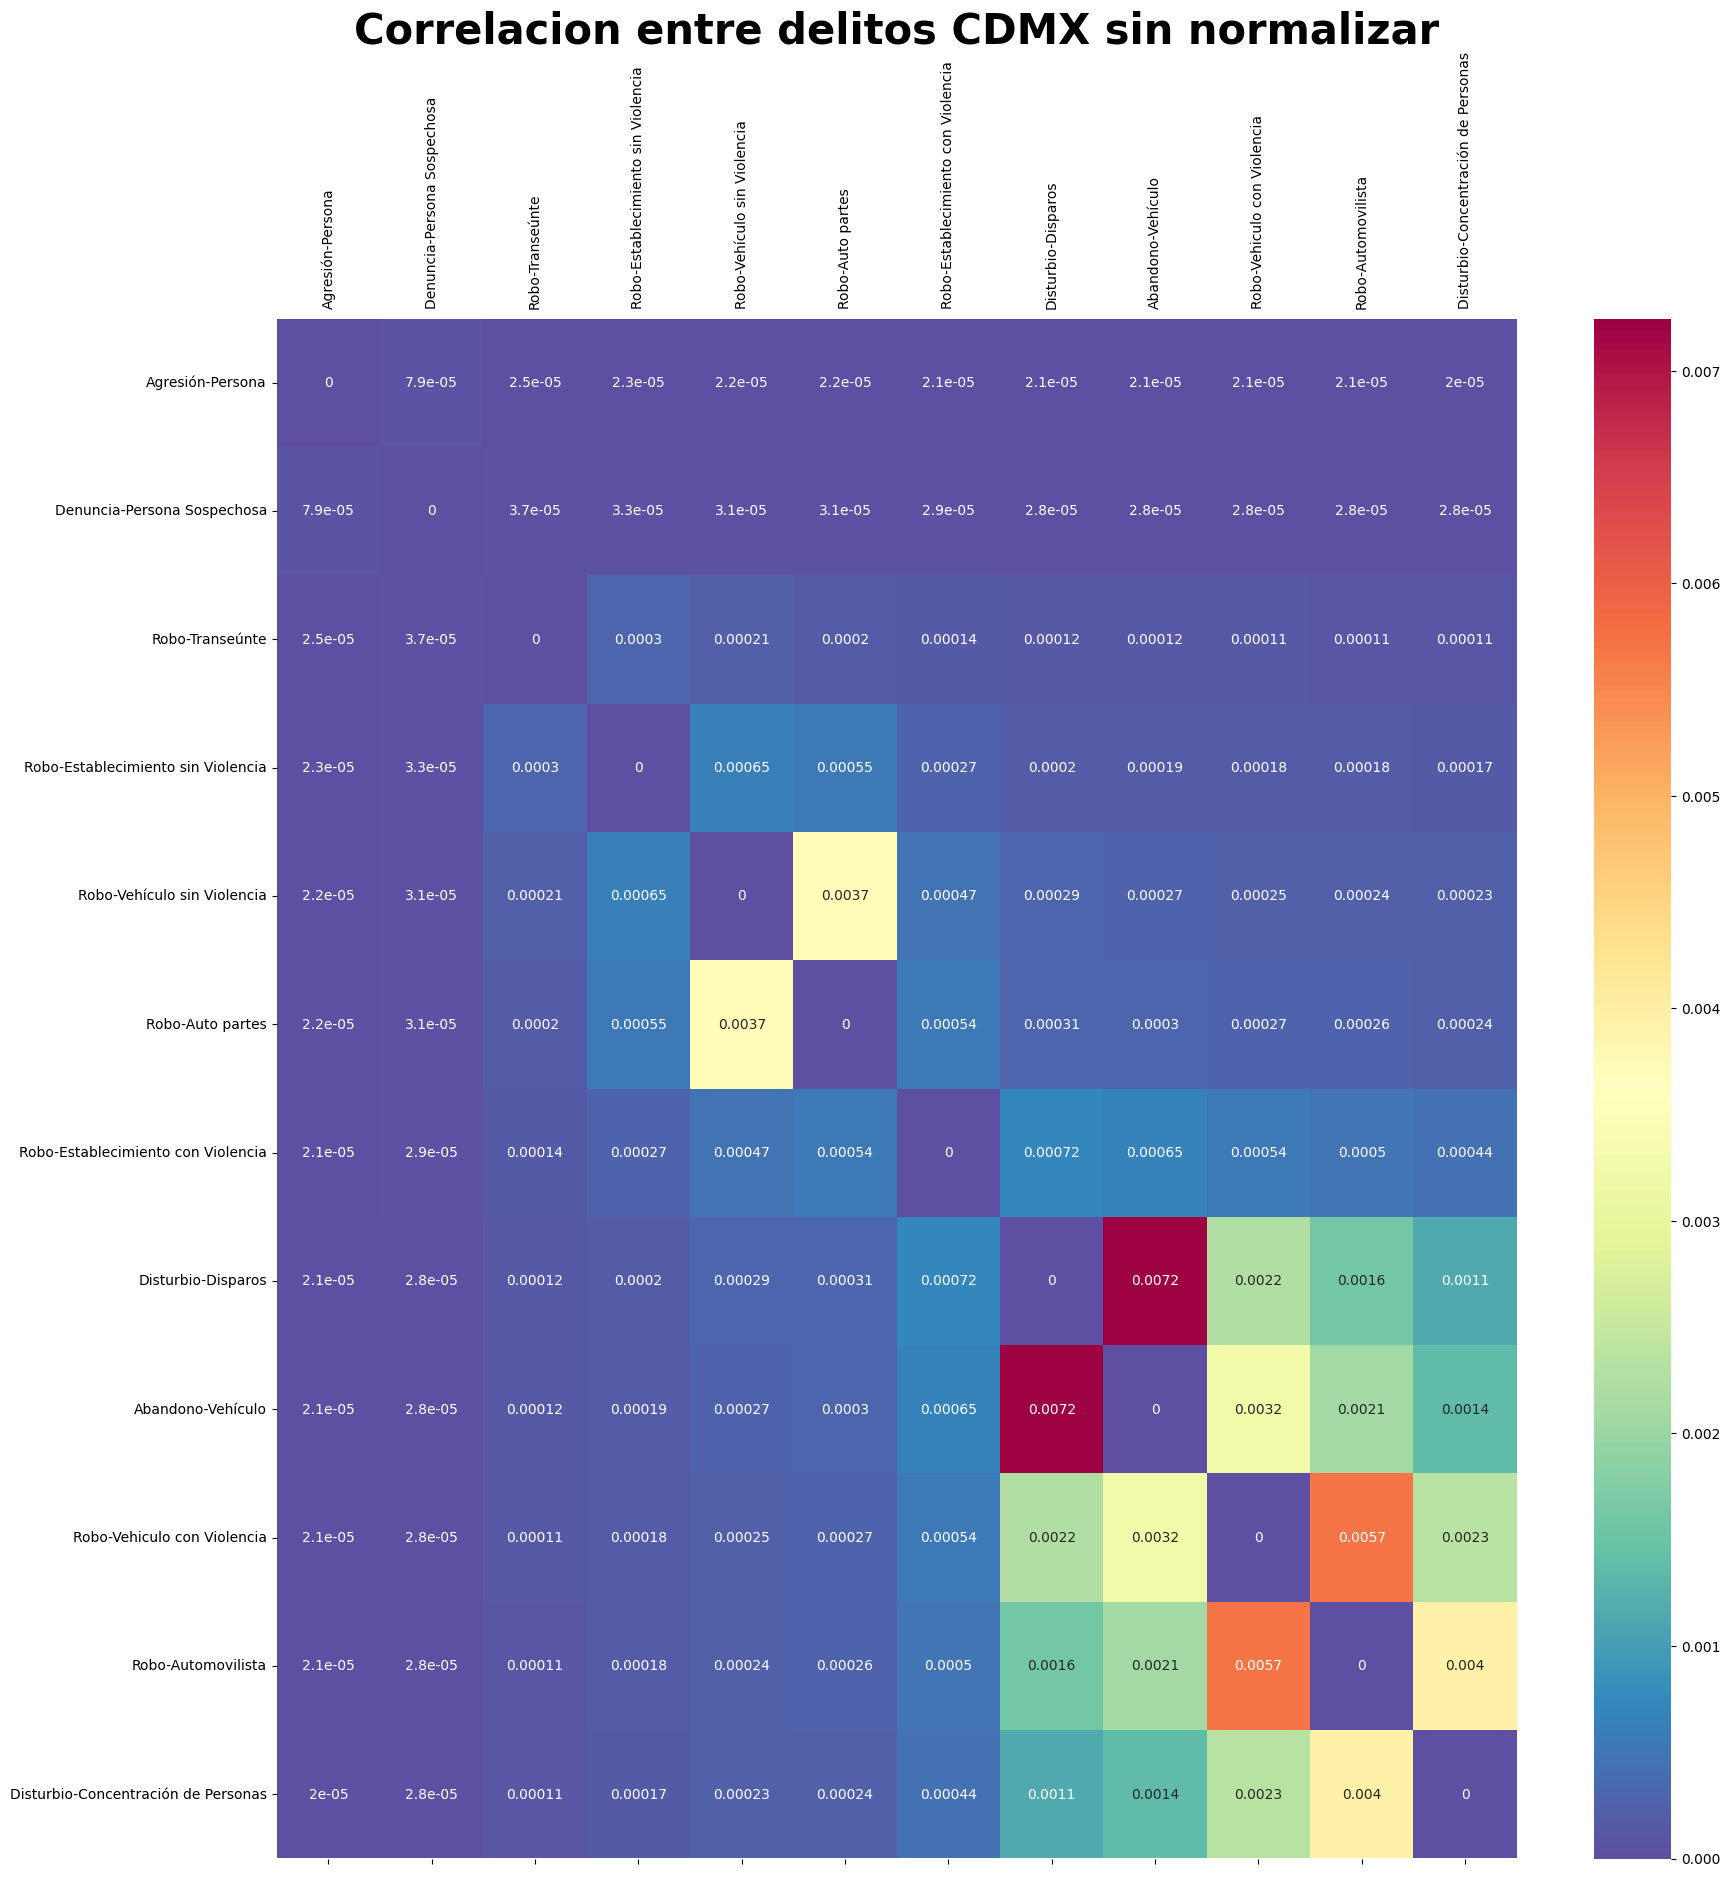

AttributeError: 'list' object has no attribute 'iloc'

In [51]:
# Correlación de delitos en CDMX

delitos_count=df['incidente_c4'].value_counts()
matriz_correlacion = correlation(delitos_count, 'Correlacion entre delitos CDMX sin normalizar')
relaciones = relaciones_mayor_menor(matriz_correlacion)

# Normalización de datos, dónde 1 es el valor más alto
delitos_count_norm=delitos_count/delitos_count.max()
matriz_correlacion_norm = correlation(delitos_count_norm, 'Correlacion entre delitos CDMX normalizado')
relaciones_norm = relaciones_mayor_menor(matriz_correlacion_norm)

#create directory correlaciones
if not os.path.exists('correlaciones'):
	os.makedirs('correlaciones')

#Save it in excel
import pandas as pd
#join relaciones and relaciones_norm
relaciones = [relaciones[i]+relaciones_norm[i] for i in range(len(relaciones))]
df_cor = pd.DataFrame(relaciones, columns = ['Delito 1', 'Delito 2', 'Correlacion', 'Delito 1 Normalizado', 'Delito 2 Normalizado', 'Correlacion Normalizada'])
df_cor.to_excel(f'correlaciones/{delegacion}.xlsx', index=False)






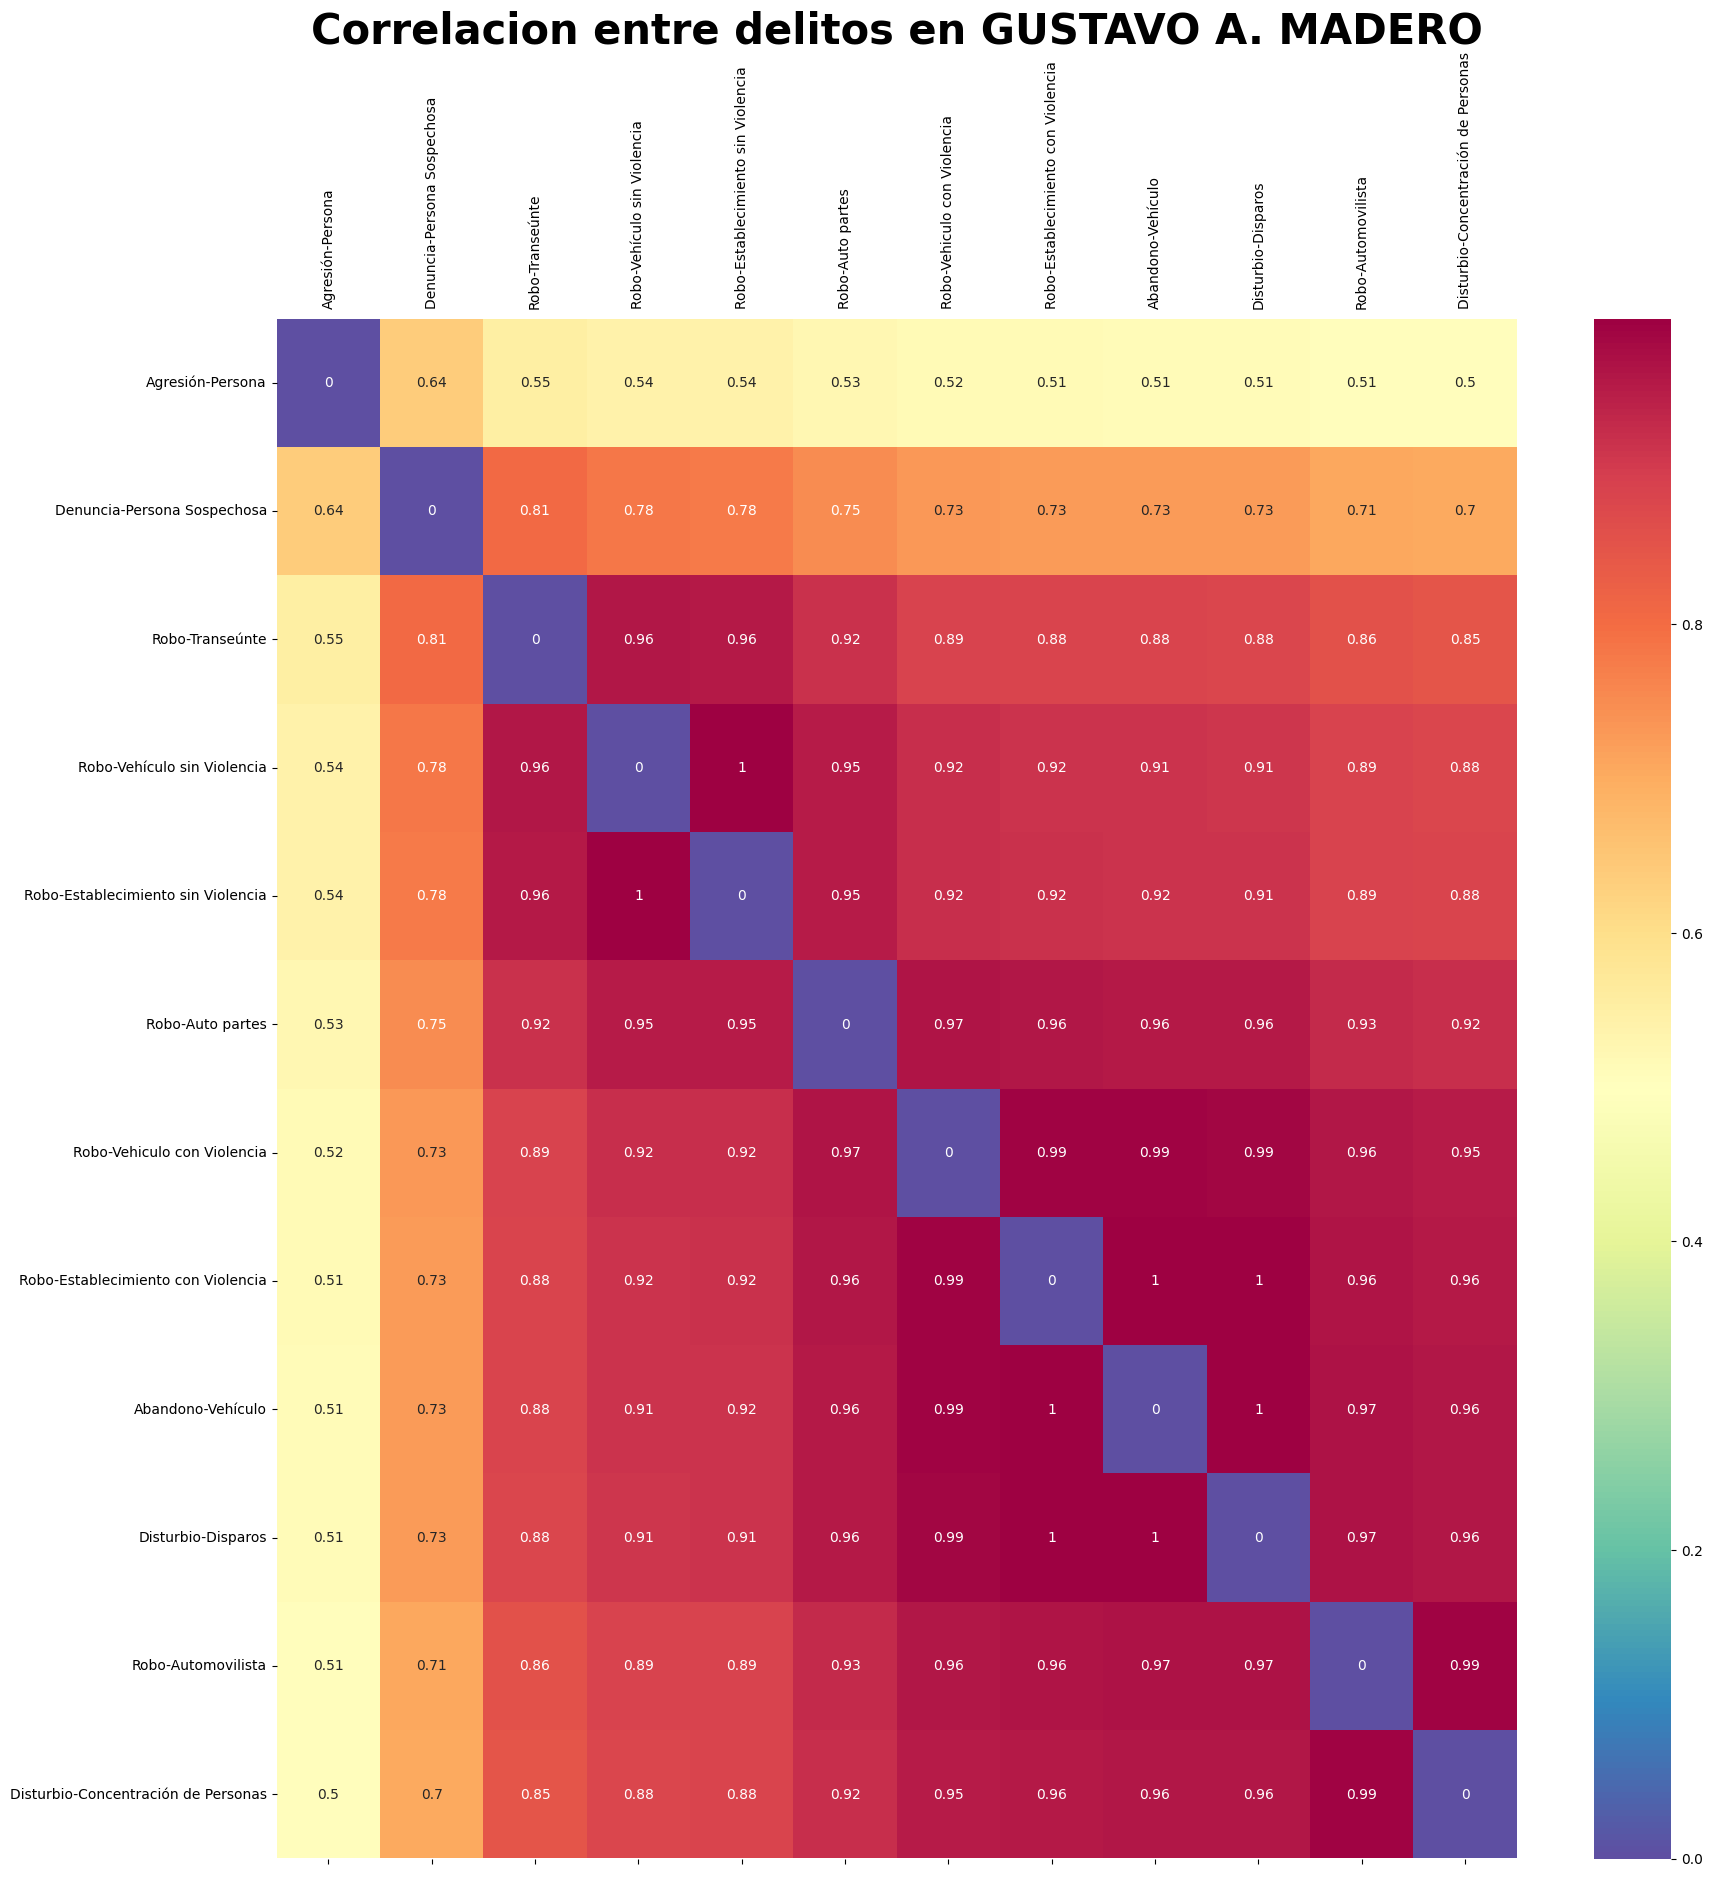

Las 5 relaciones mas fuertes en GUSTAVO A. MADERO son:
Abandono-Vehículo - Disturbio-Disparos: 0.9981562185719076
Robo-Establecimiento con Violencia - Abandono-Vehículo: 0.9976545485005863
Robo-Vehículo sin Violencia - Robo-Establecimiento sin Violencia: 0.9969864389753892
Robo-Establecimiento con Violencia - Disturbio-Disparos: 0.9958193979933111
Robo-Vehiculo con Violencia - Robo-Establecimiento con Violencia: 0.9939909864797195



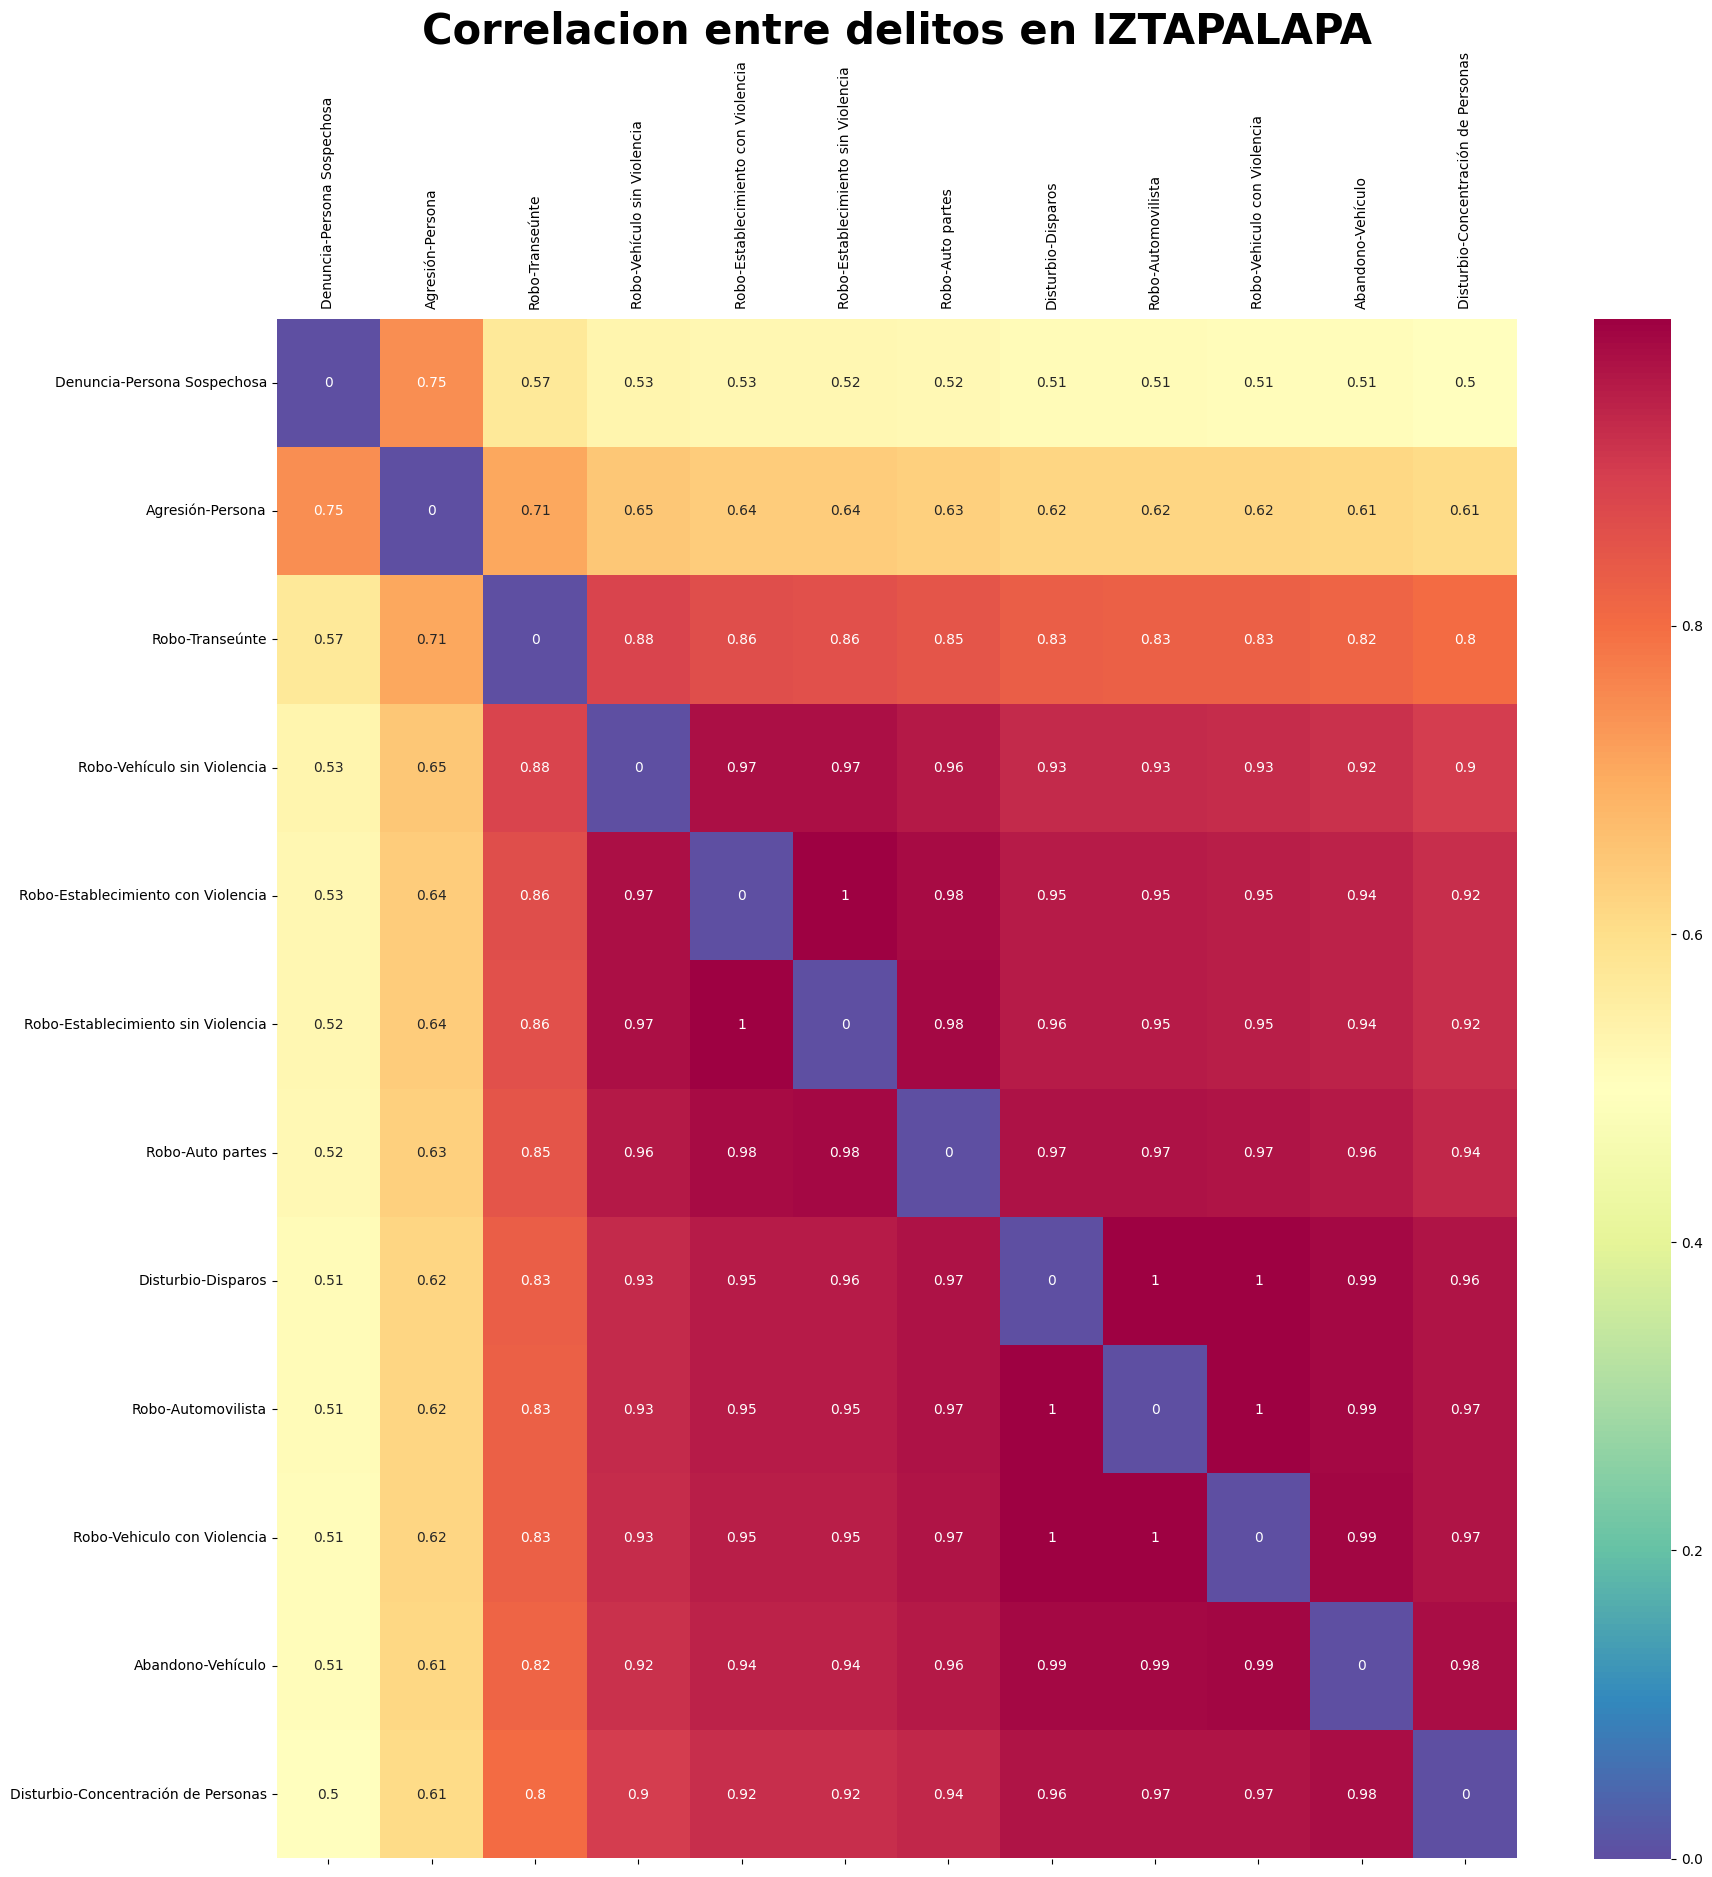

Las 5 relaciones mas fuertes en IZTAPALAPA son:
Disturbio-Disparos - Robo-Automovilista: 0.9992738714752512
Robo-Establecimiento con Violencia - Robo-Establecimiento sin Violencia: 0.9979453710418177
Robo-Automovilista - Robo-Vehiculo con Violencia: 0.9971017992996015
Disturbio-Disparos - Robo-Vehiculo con Violencia: 0.9963798720888138
Robo-Vehiculo con Violencia - Abandono-Vehículo: 0.9895733461169703



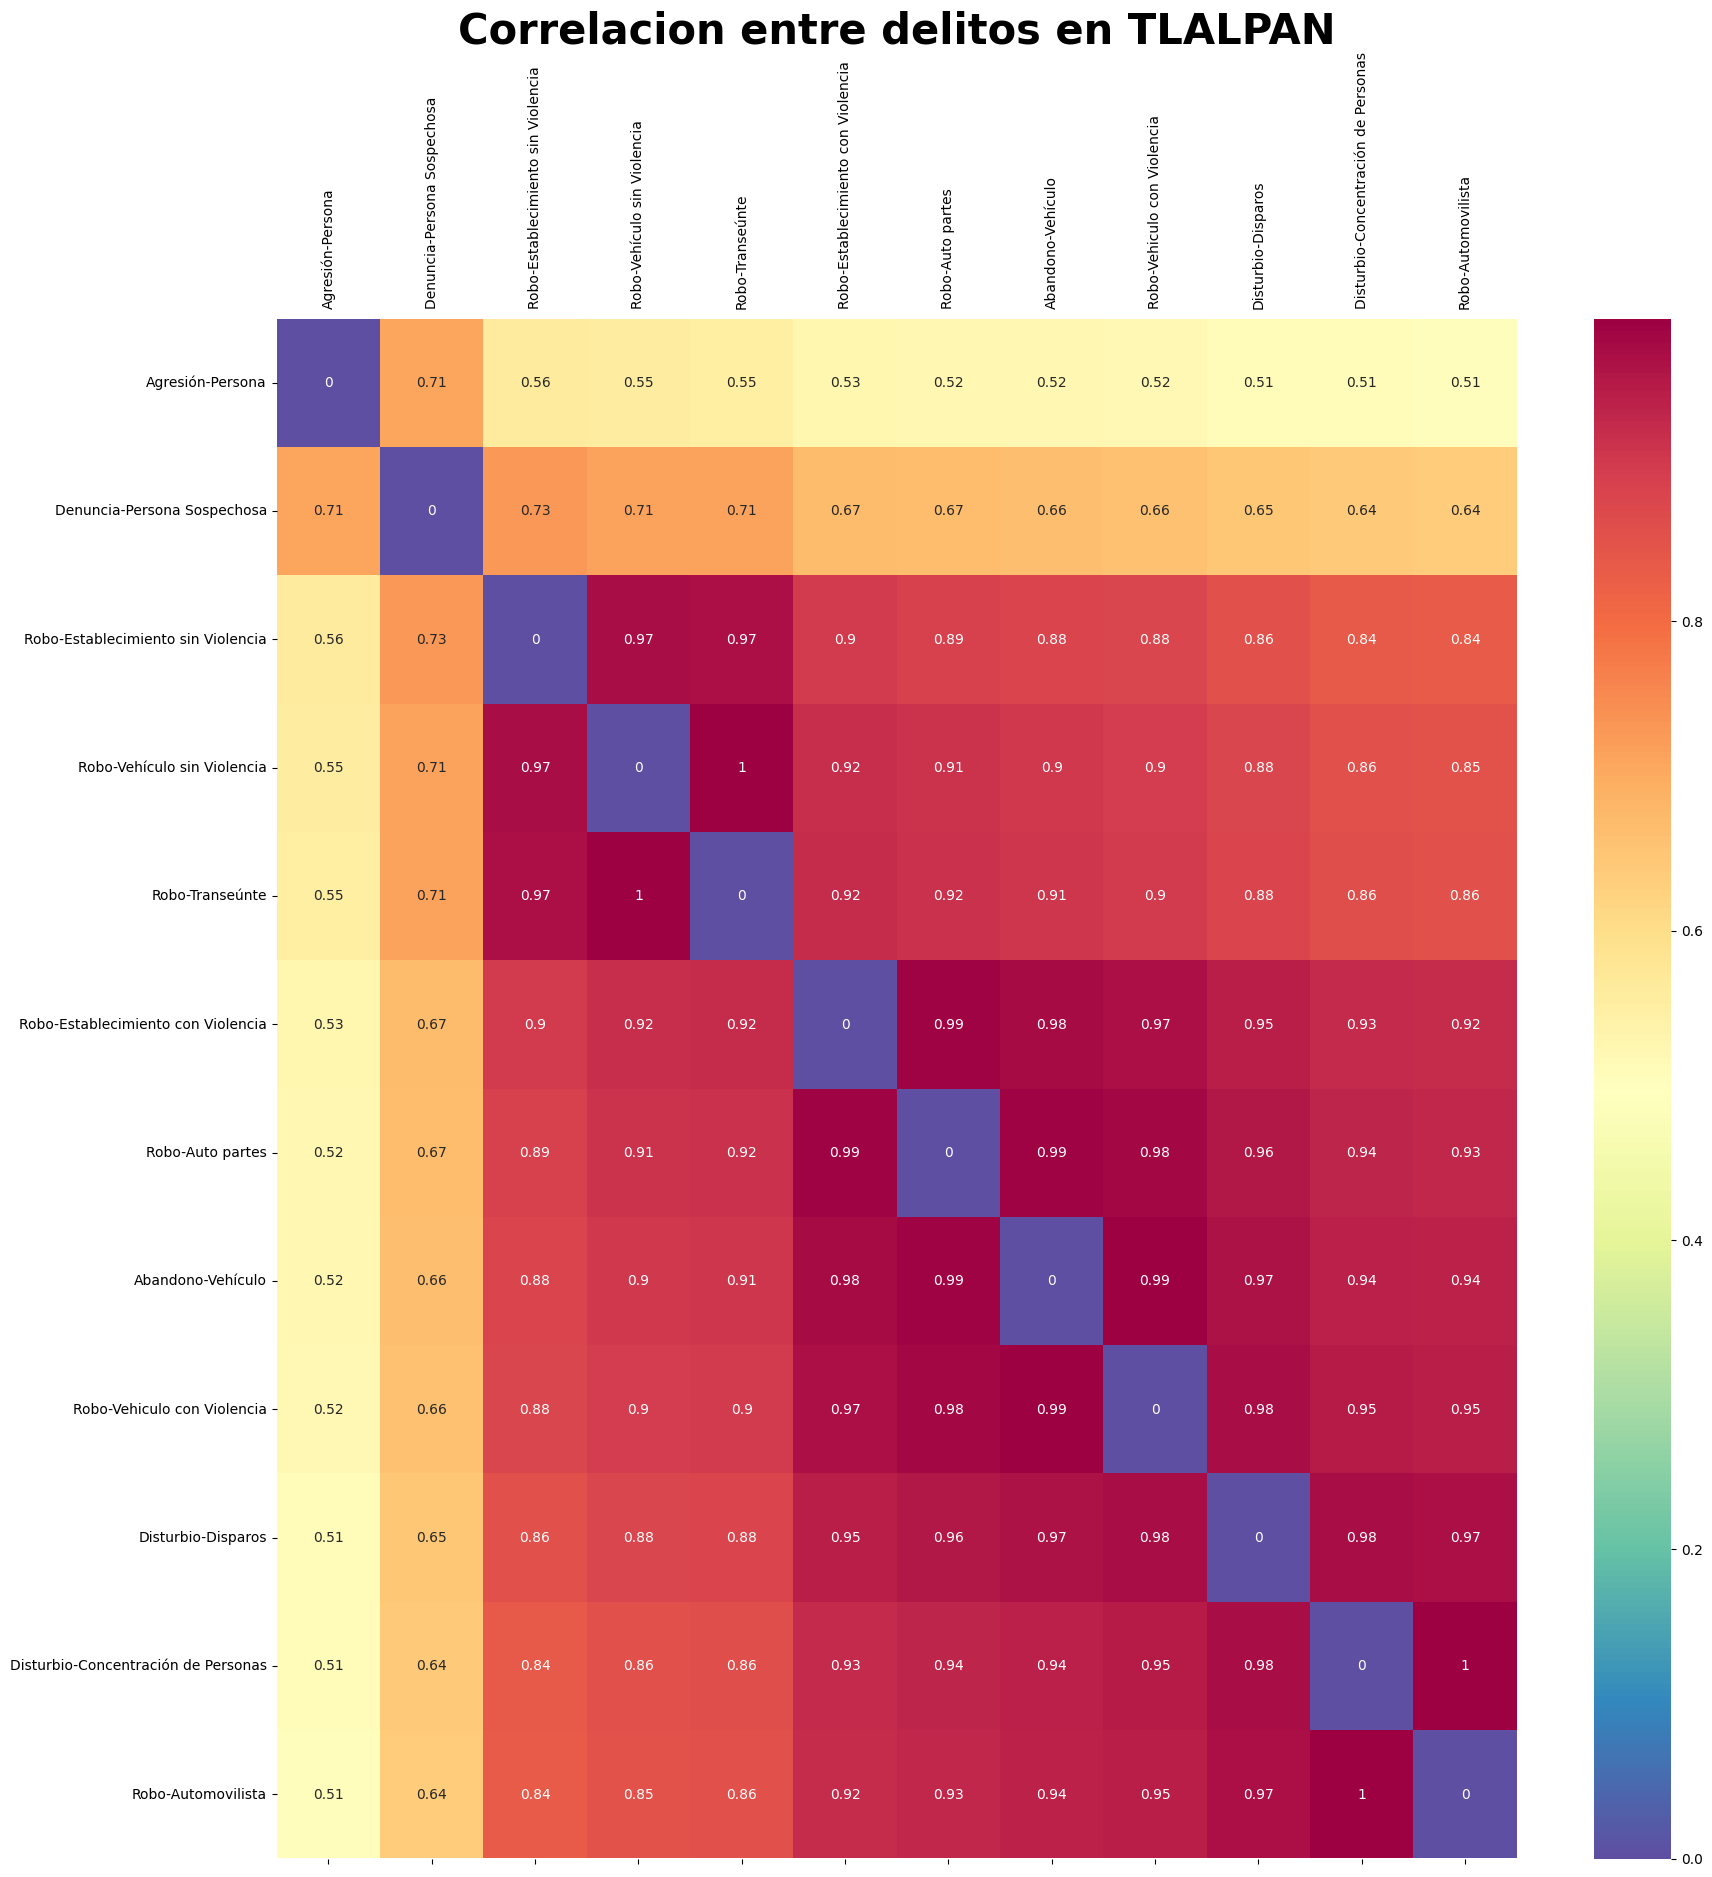

Las 5 relaciones mas fuertes en TLALPAN son:
Robo-Vehículo sin Violencia - Robo-Transeúnte: 0.9957163255592575
Disturbio-Concentración de Personas - Robo-Automovilista: 0.9957163255592575
Abandono-Vehículo - Robo-Vehiculo con Violencia: 0.9919393077287815
Robo-Establecimiento con Violencia - Robo-Auto partes: 0.989593188268685
Robo-Auto partes - Abandono-Vehículo: 0.9891252955082743



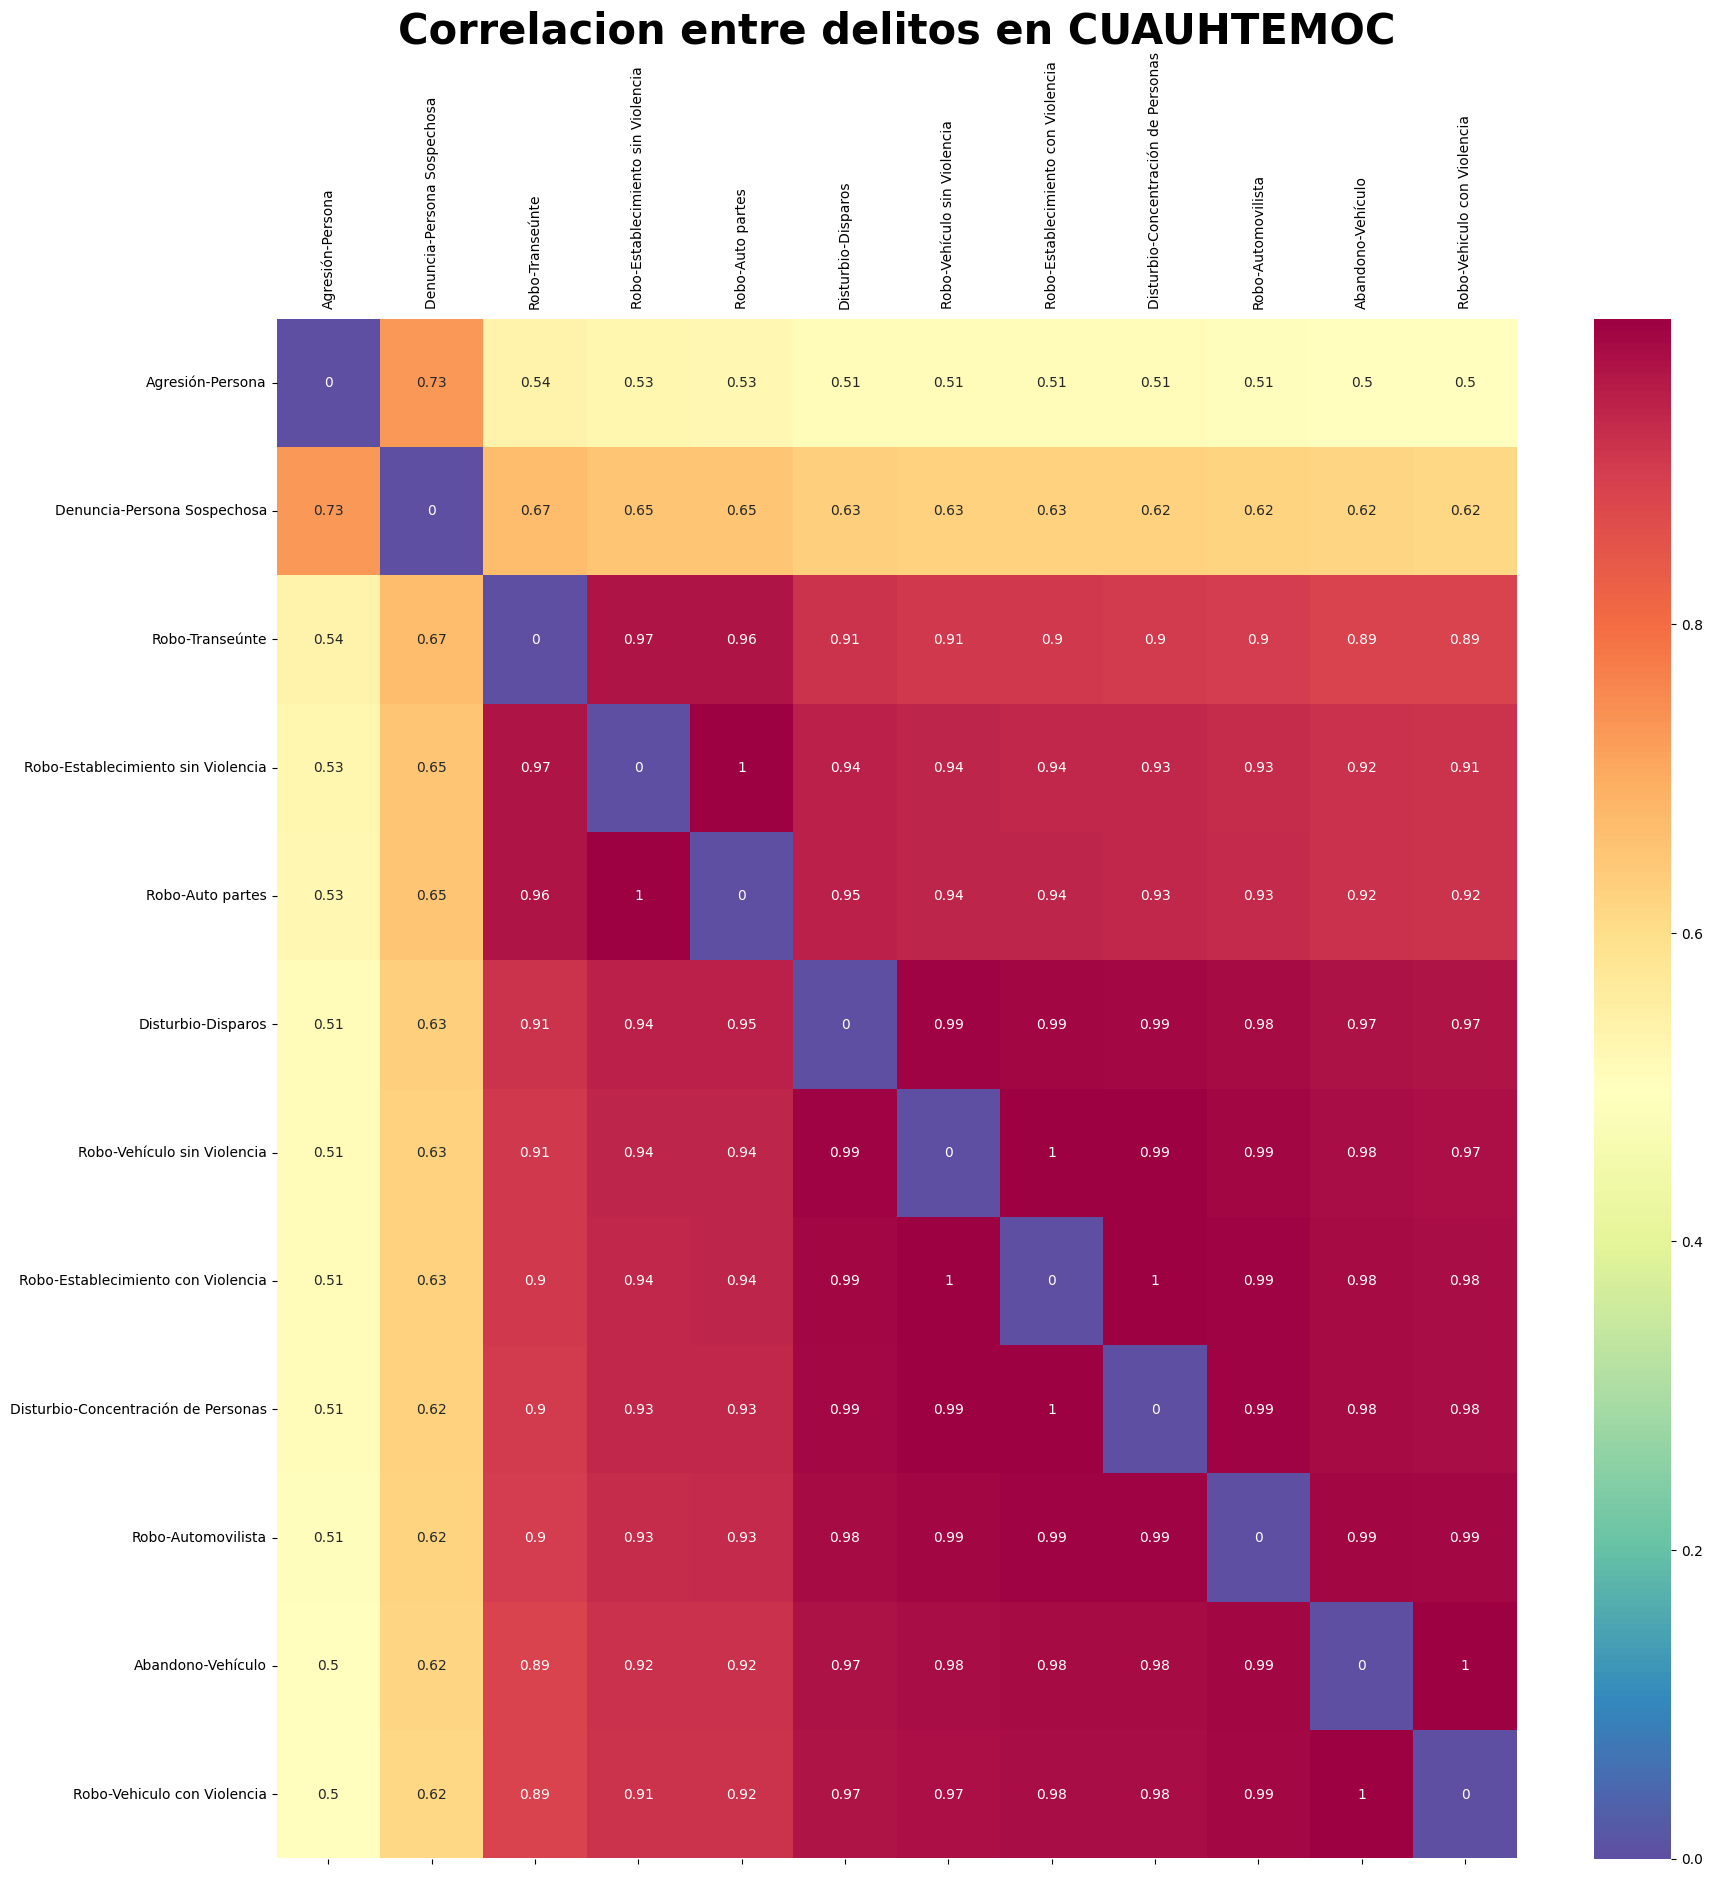

Las 5 relaciones mas fuertes en CUAUHTEMOC son:
Robo-Establecimiento sin Violencia - Robo-Auto partes: 0.9983262042030874
Robo-Establecimiento con Violencia - Disturbio-Concentración de Personas: 0.9974605140910497
Robo-Vehículo sin Violencia - Robo-Establecimiento con Violencia: 0.9971517027863778
Abandono-Vehículo - Robo-Vehiculo con Violencia: 0.9969665077694546
Robo-Vehículo sin Violencia - Disturbio-Concentración de Personas: 0.9946266444320919



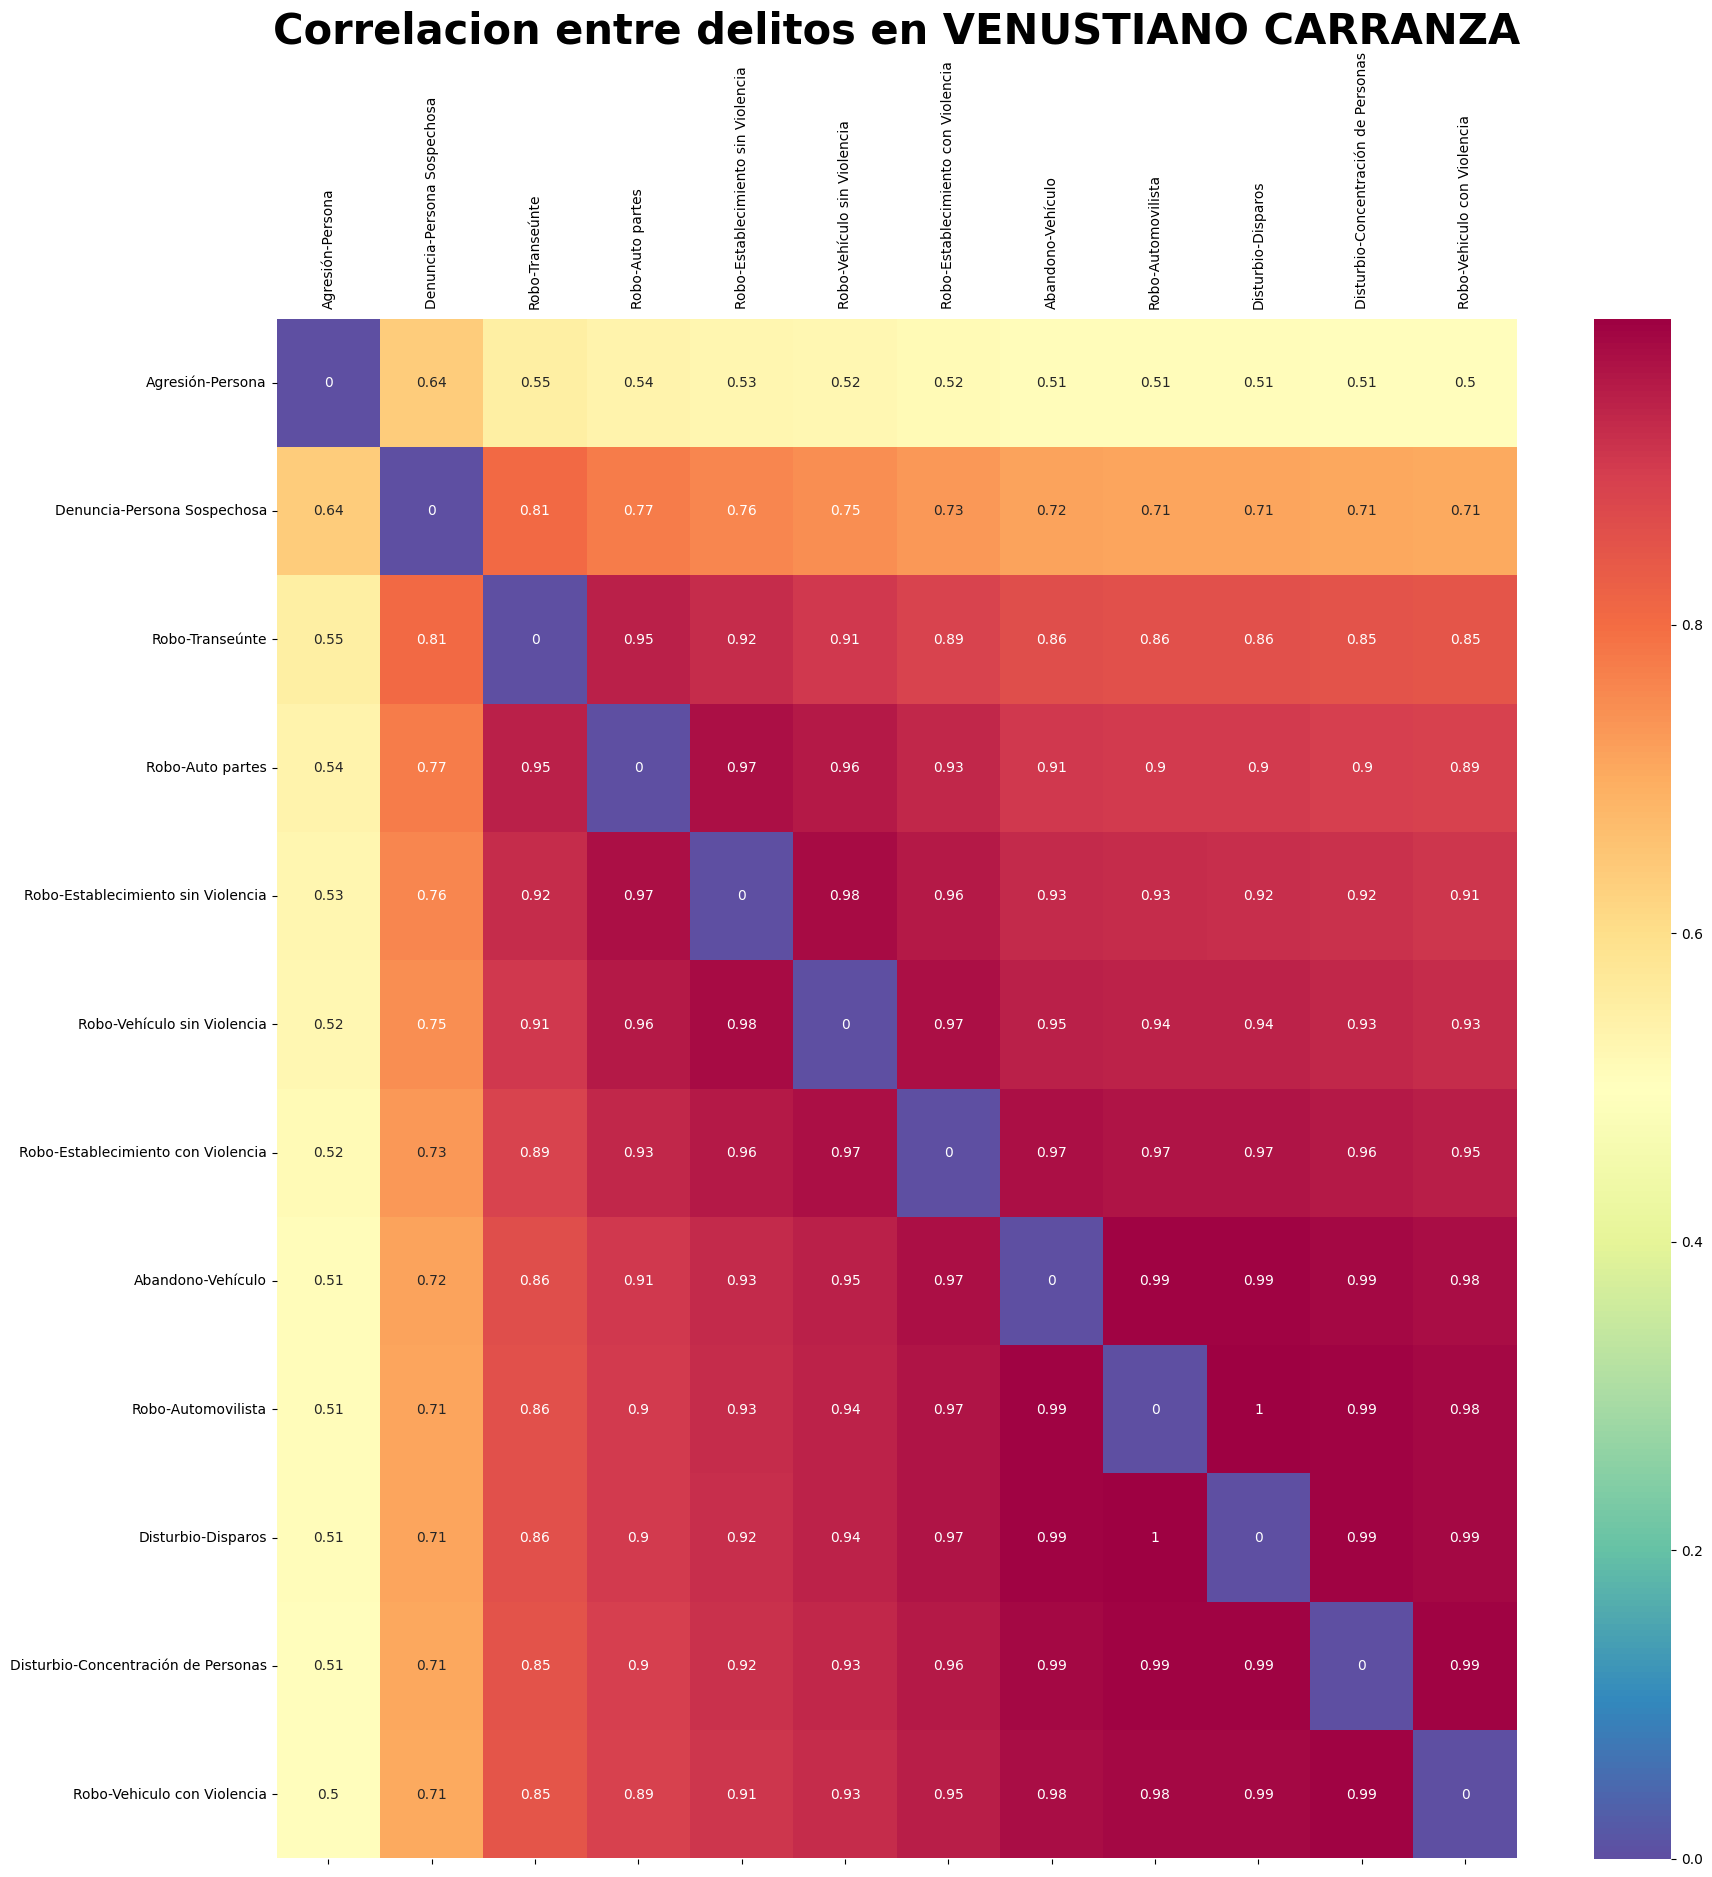

Las 5 relaciones mas fuertes en VENUSTIANO CARRANZA son:
Robo-Automovilista - Disturbio-Disparos: 0.9985163204747775
Abandono-Vehículo - Robo-Automovilista: 0.9937979917306556
Disturbio-Disparos - Disturbio-Concentración de Personas: 0.9929182649749189
Disturbio-Concentración de Personas - Robo-Vehiculo con Violencia: 0.9926253687315635
Abandono-Vehículo - Disturbio-Disparos: 0.9923326452373932



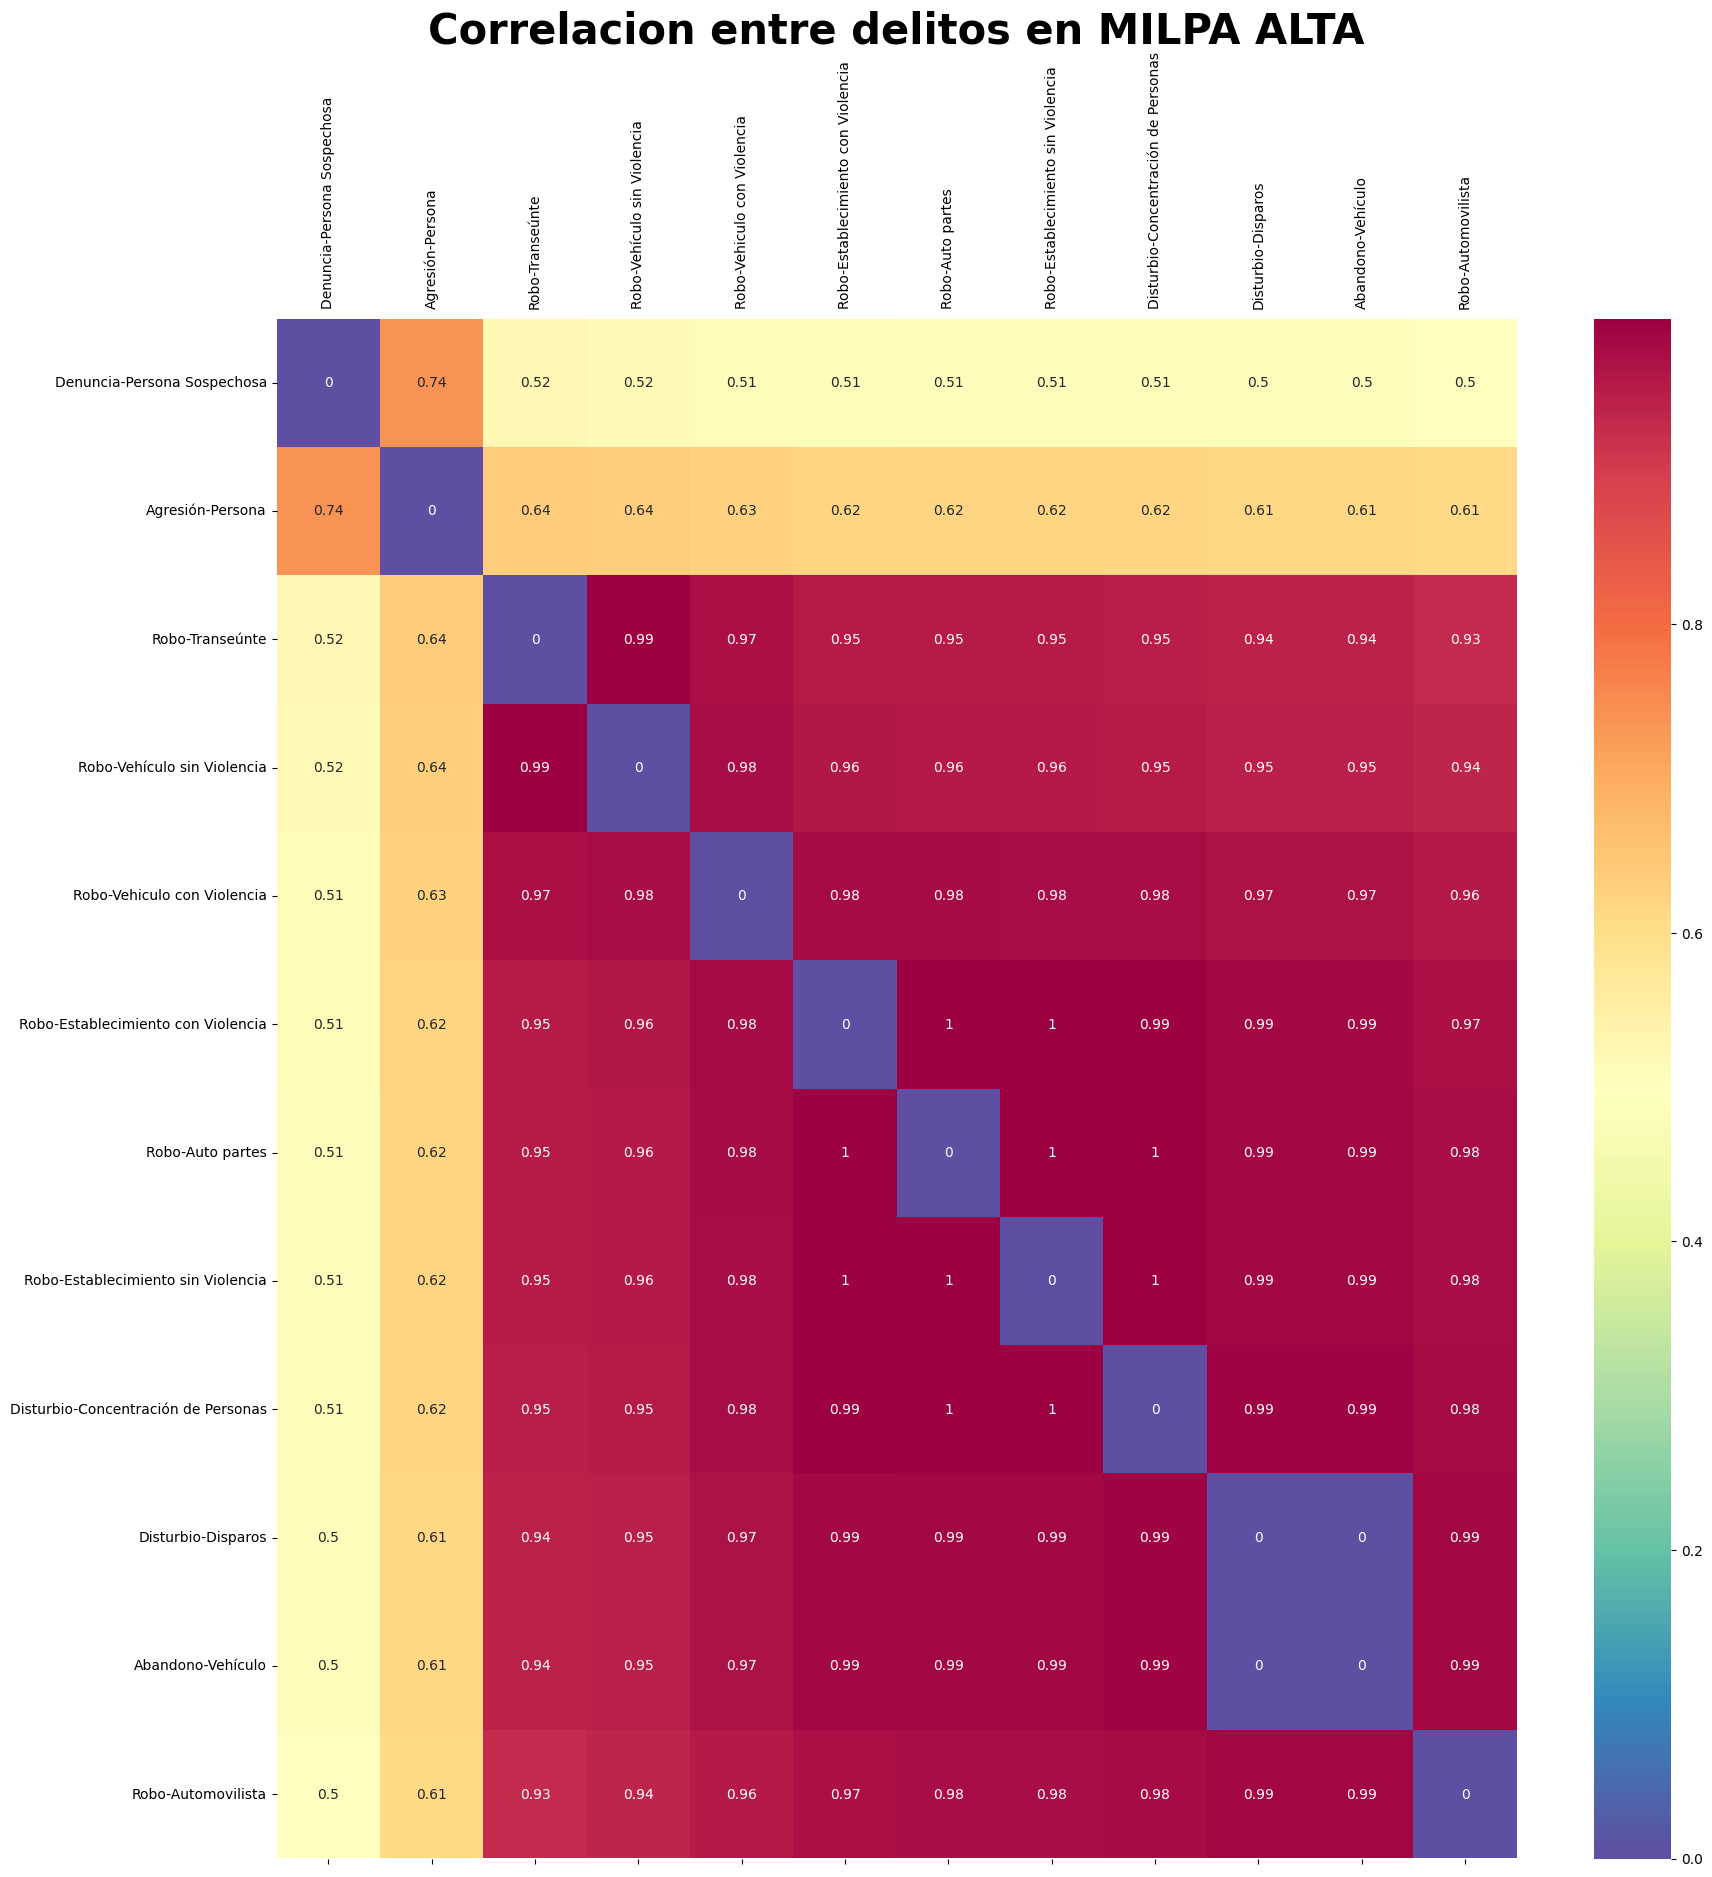

Las 5 relaciones mas fuertes en MILPA ALTA son:
Robo-Establecimiento con Violencia - Robo-Auto partes: 0.9982486865148862
Robo-Auto partes - Robo-Establecimiento sin Violencia: 0.9982486865148862
Robo-Establecimiento sin Violencia - Disturbio-Concentración de Personas: 0.9982486865148862
Robo-Establecimiento con Violencia - Robo-Establecimiento sin Violencia: 0.9965034965034965
Robo-Auto partes - Disturbio-Concentración de Personas: 0.9965034965034965



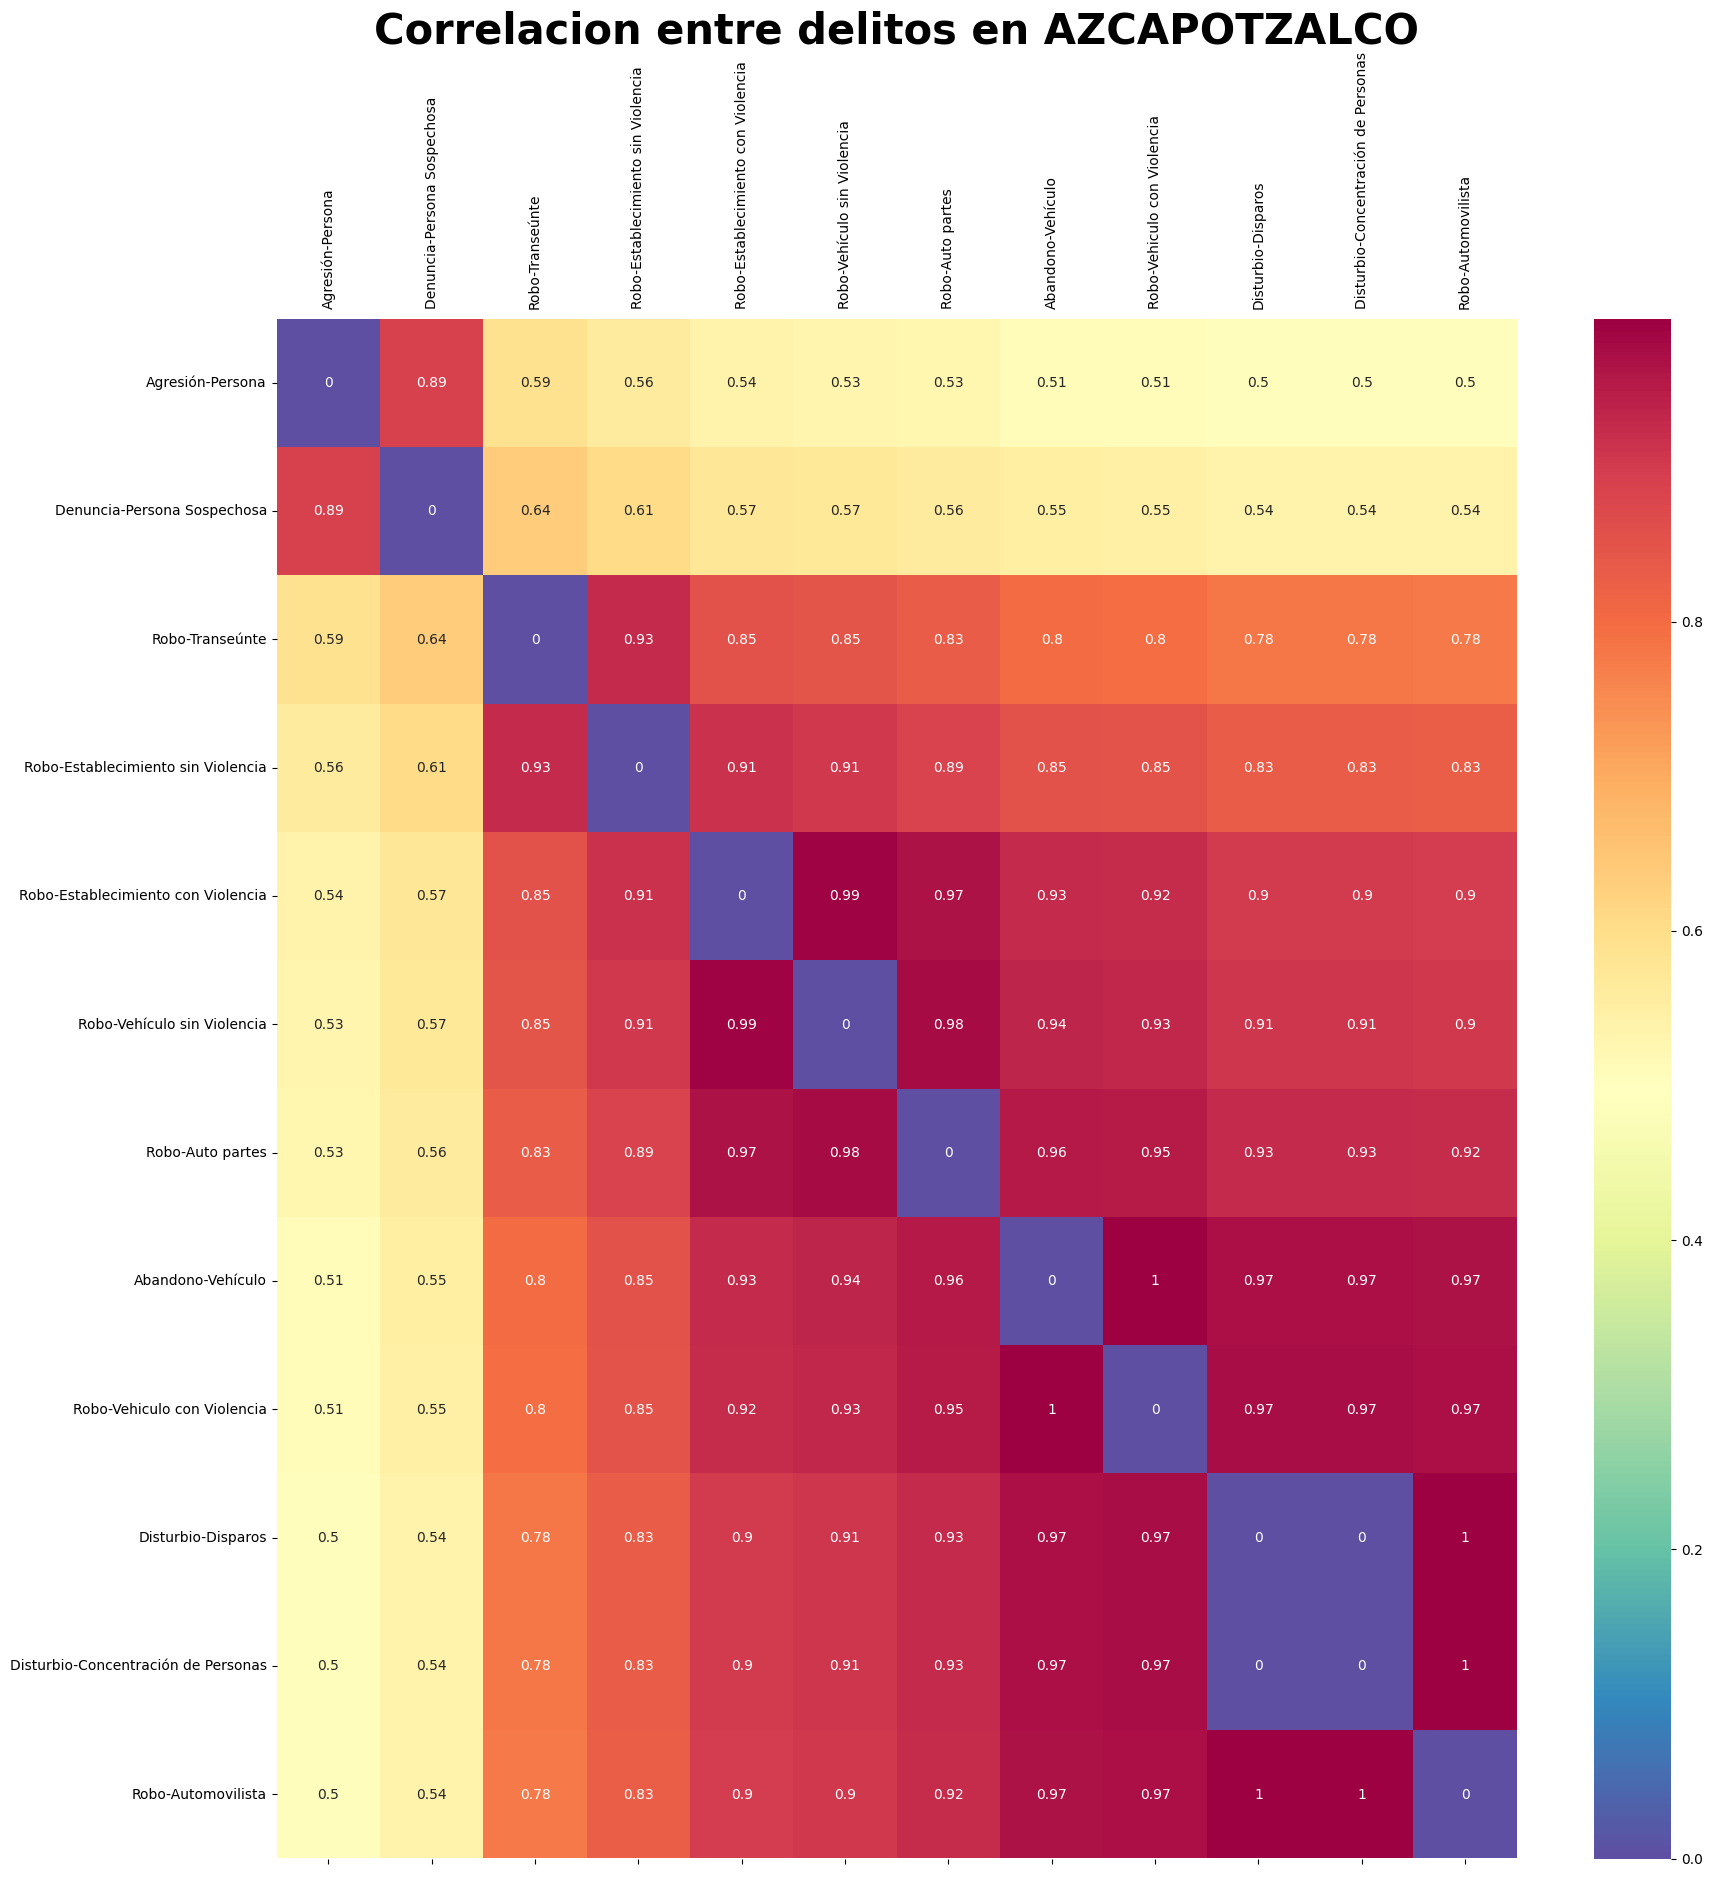

Las 5 relaciones mas fuertes en AZCAPOTZALCO son:
Abandono-Vehículo - Robo-Vehiculo con Violencia: 0.995967741935484
Disturbio-Disparos - Robo-Automovilista: 0.995967741935484
Disturbio-Concentración de Personas - Robo-Automovilista: 0.995967741935484
Robo-Establecimiento con Violencia - Robo-Vehículo sin Violencia: 0.989696622781912
Robo-Vehículo sin Violencia - Robo-Auto partes: 0.9768361581920904



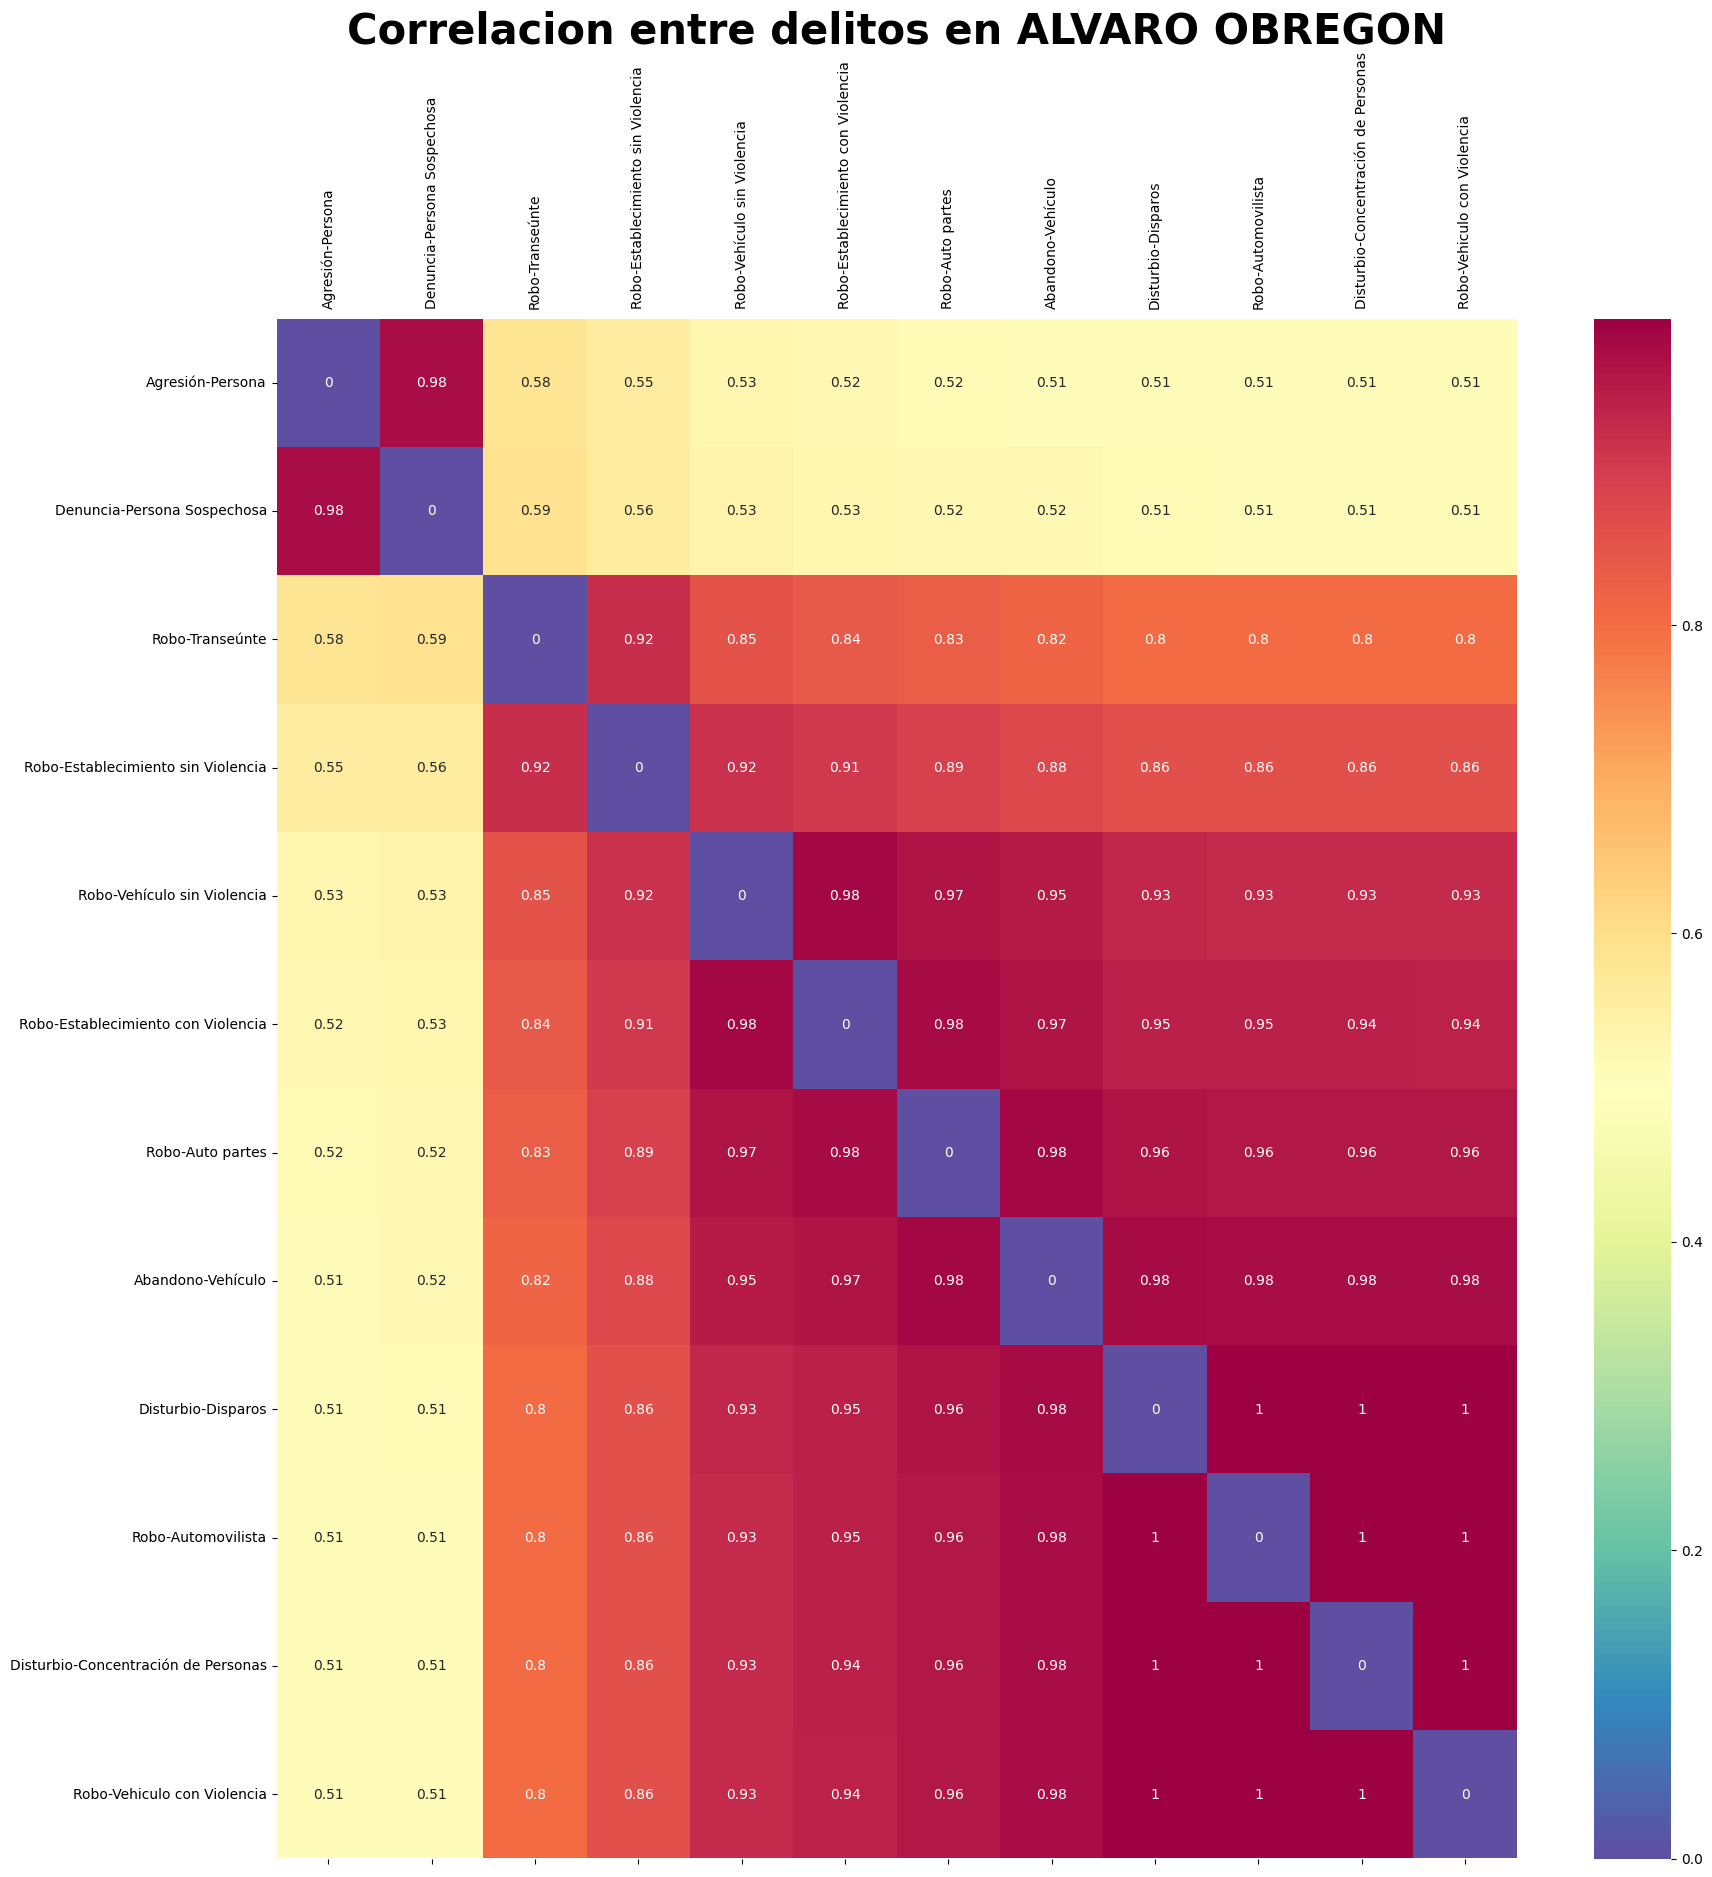

Las 5 relaciones mas fuertes en ALVARO OBREGON son:
Robo-Automovilista - Disturbio-Concentración de Personas: 0.9986104678091711
Disturbio-Disparos - Robo-Automovilista: 0.9986104678091708
Disturbio-Concentración de Personas - Robo-Vehiculo con Violencia: 0.9986104678091708
Disturbio-Disparos - Disturbio-Concentración de Personas: 0.9972247918593895
Robo-Automovilista - Robo-Vehiculo con Violencia: 0.9972247918593895



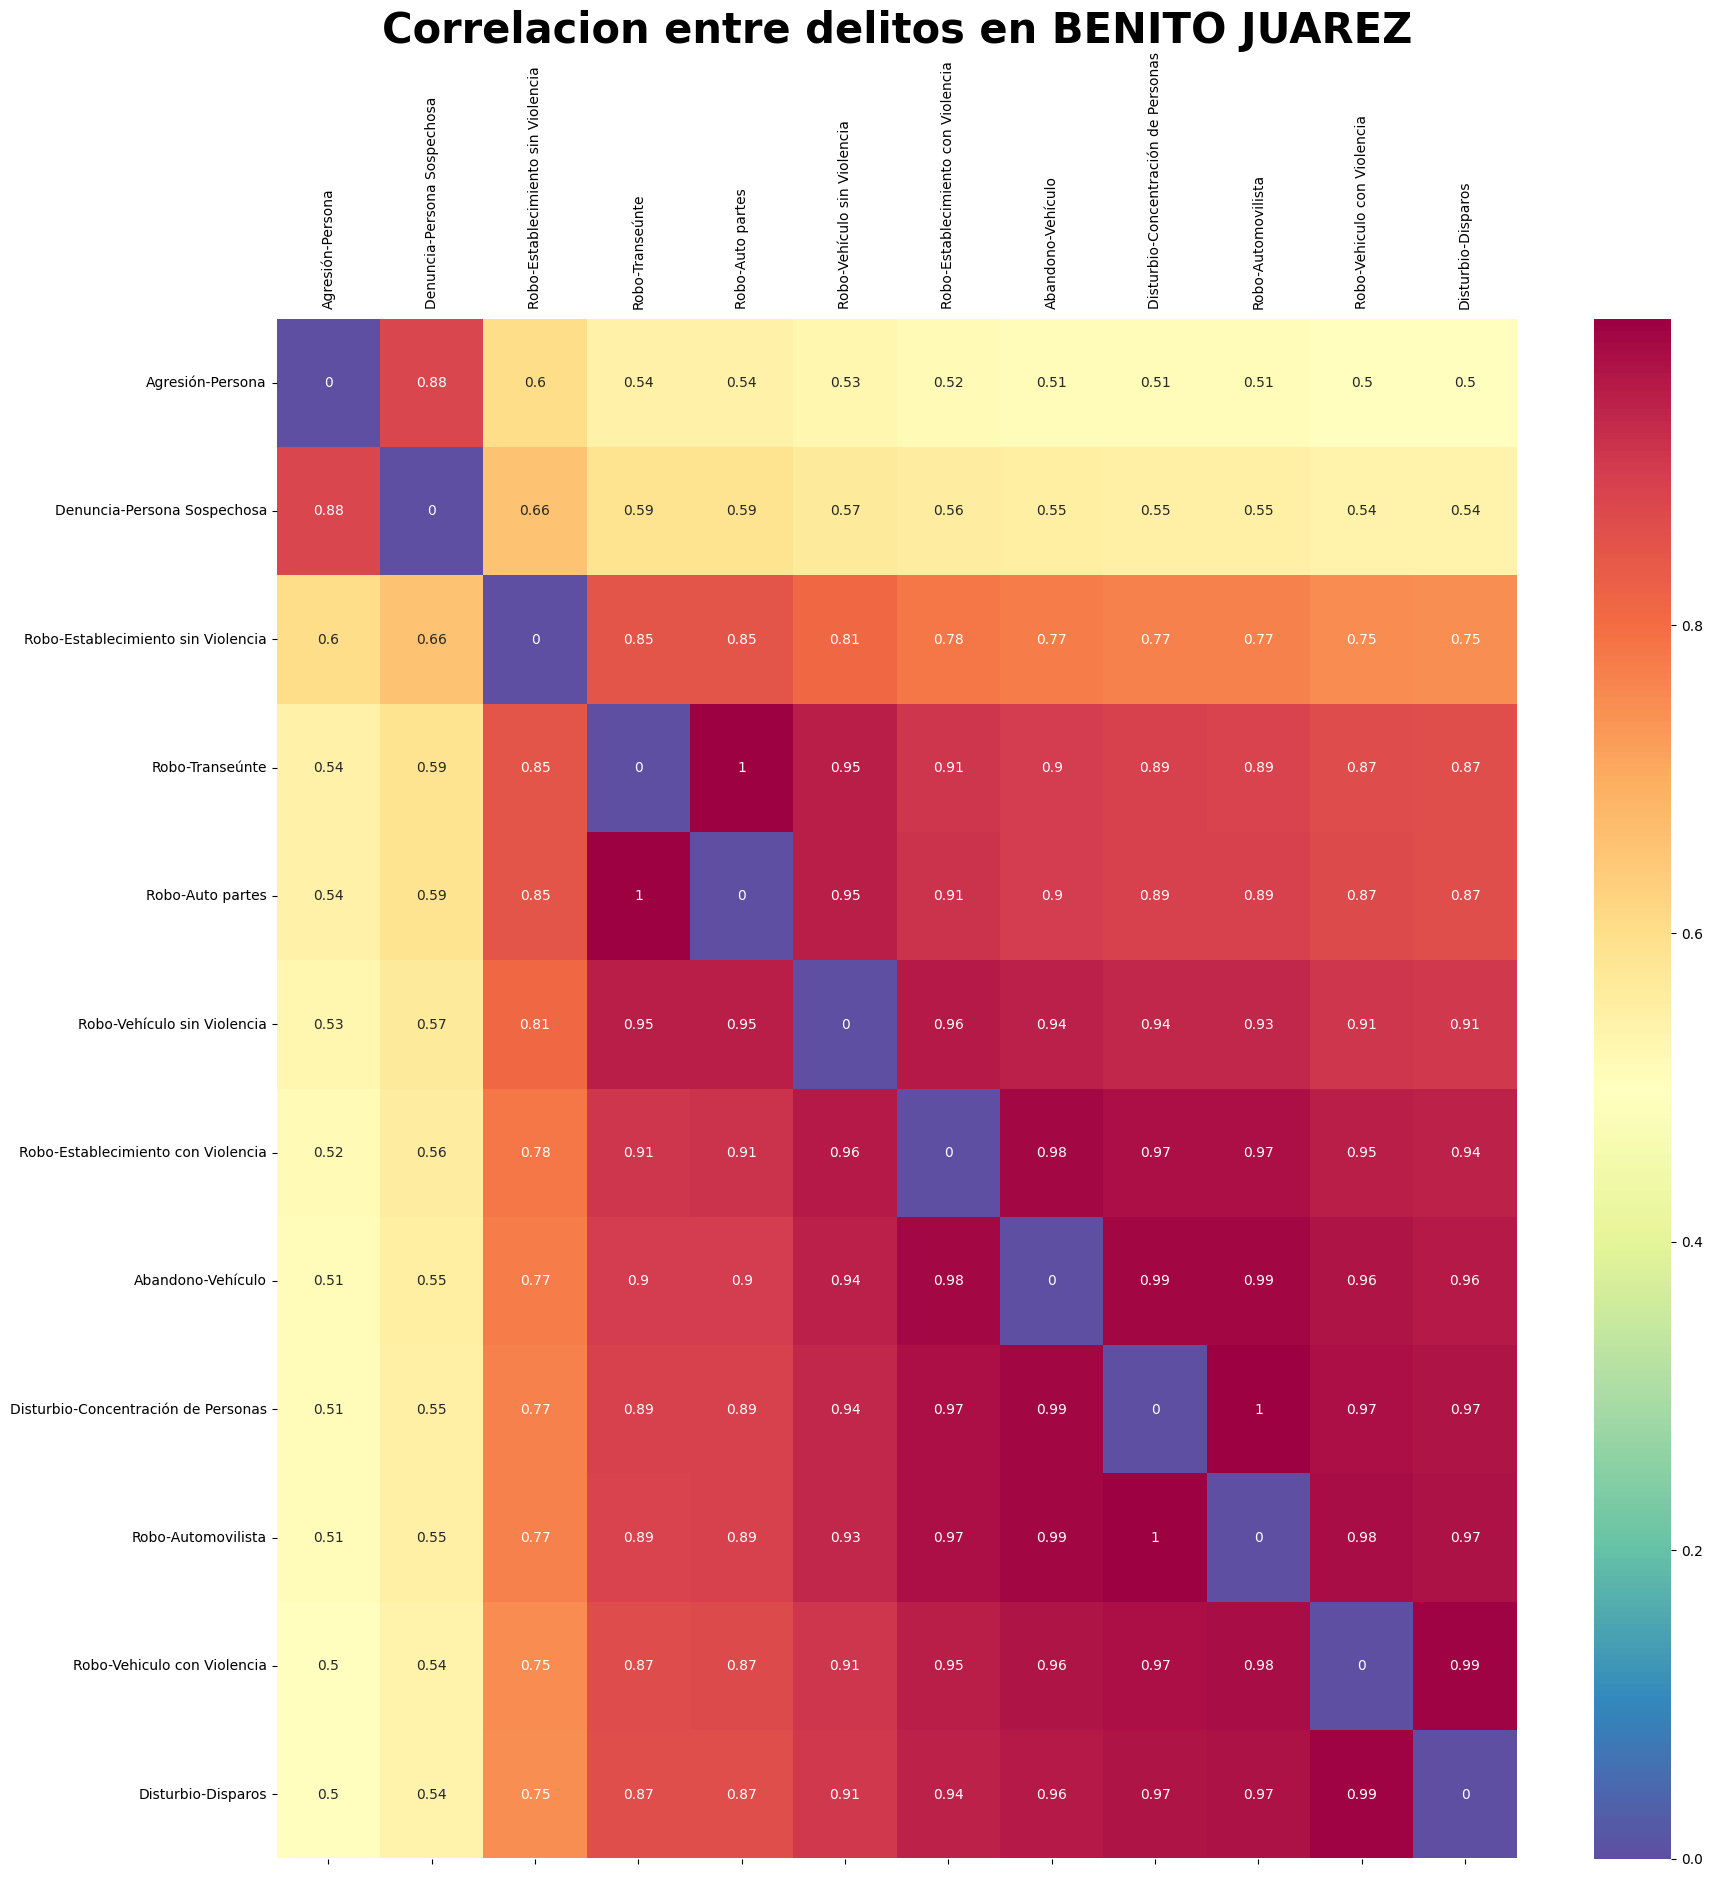

Las 5 relaciones mas fuertes en BENITO JUAREZ son:
Robo-Transeúnte - Robo-Auto partes: 0.9987603305785123
Disturbio-Concentración de Personas - Robo-Automovilista: 0.9971122112211221
Robo-Vehiculo con Violencia - Disturbio-Disparos: 0.9942410530645824
Abandono-Vehículo - Disturbio-Concentración de Personas: 0.9905737704918032
Abandono-Vehículo - Robo-Automovilista: 0.9877400899060073



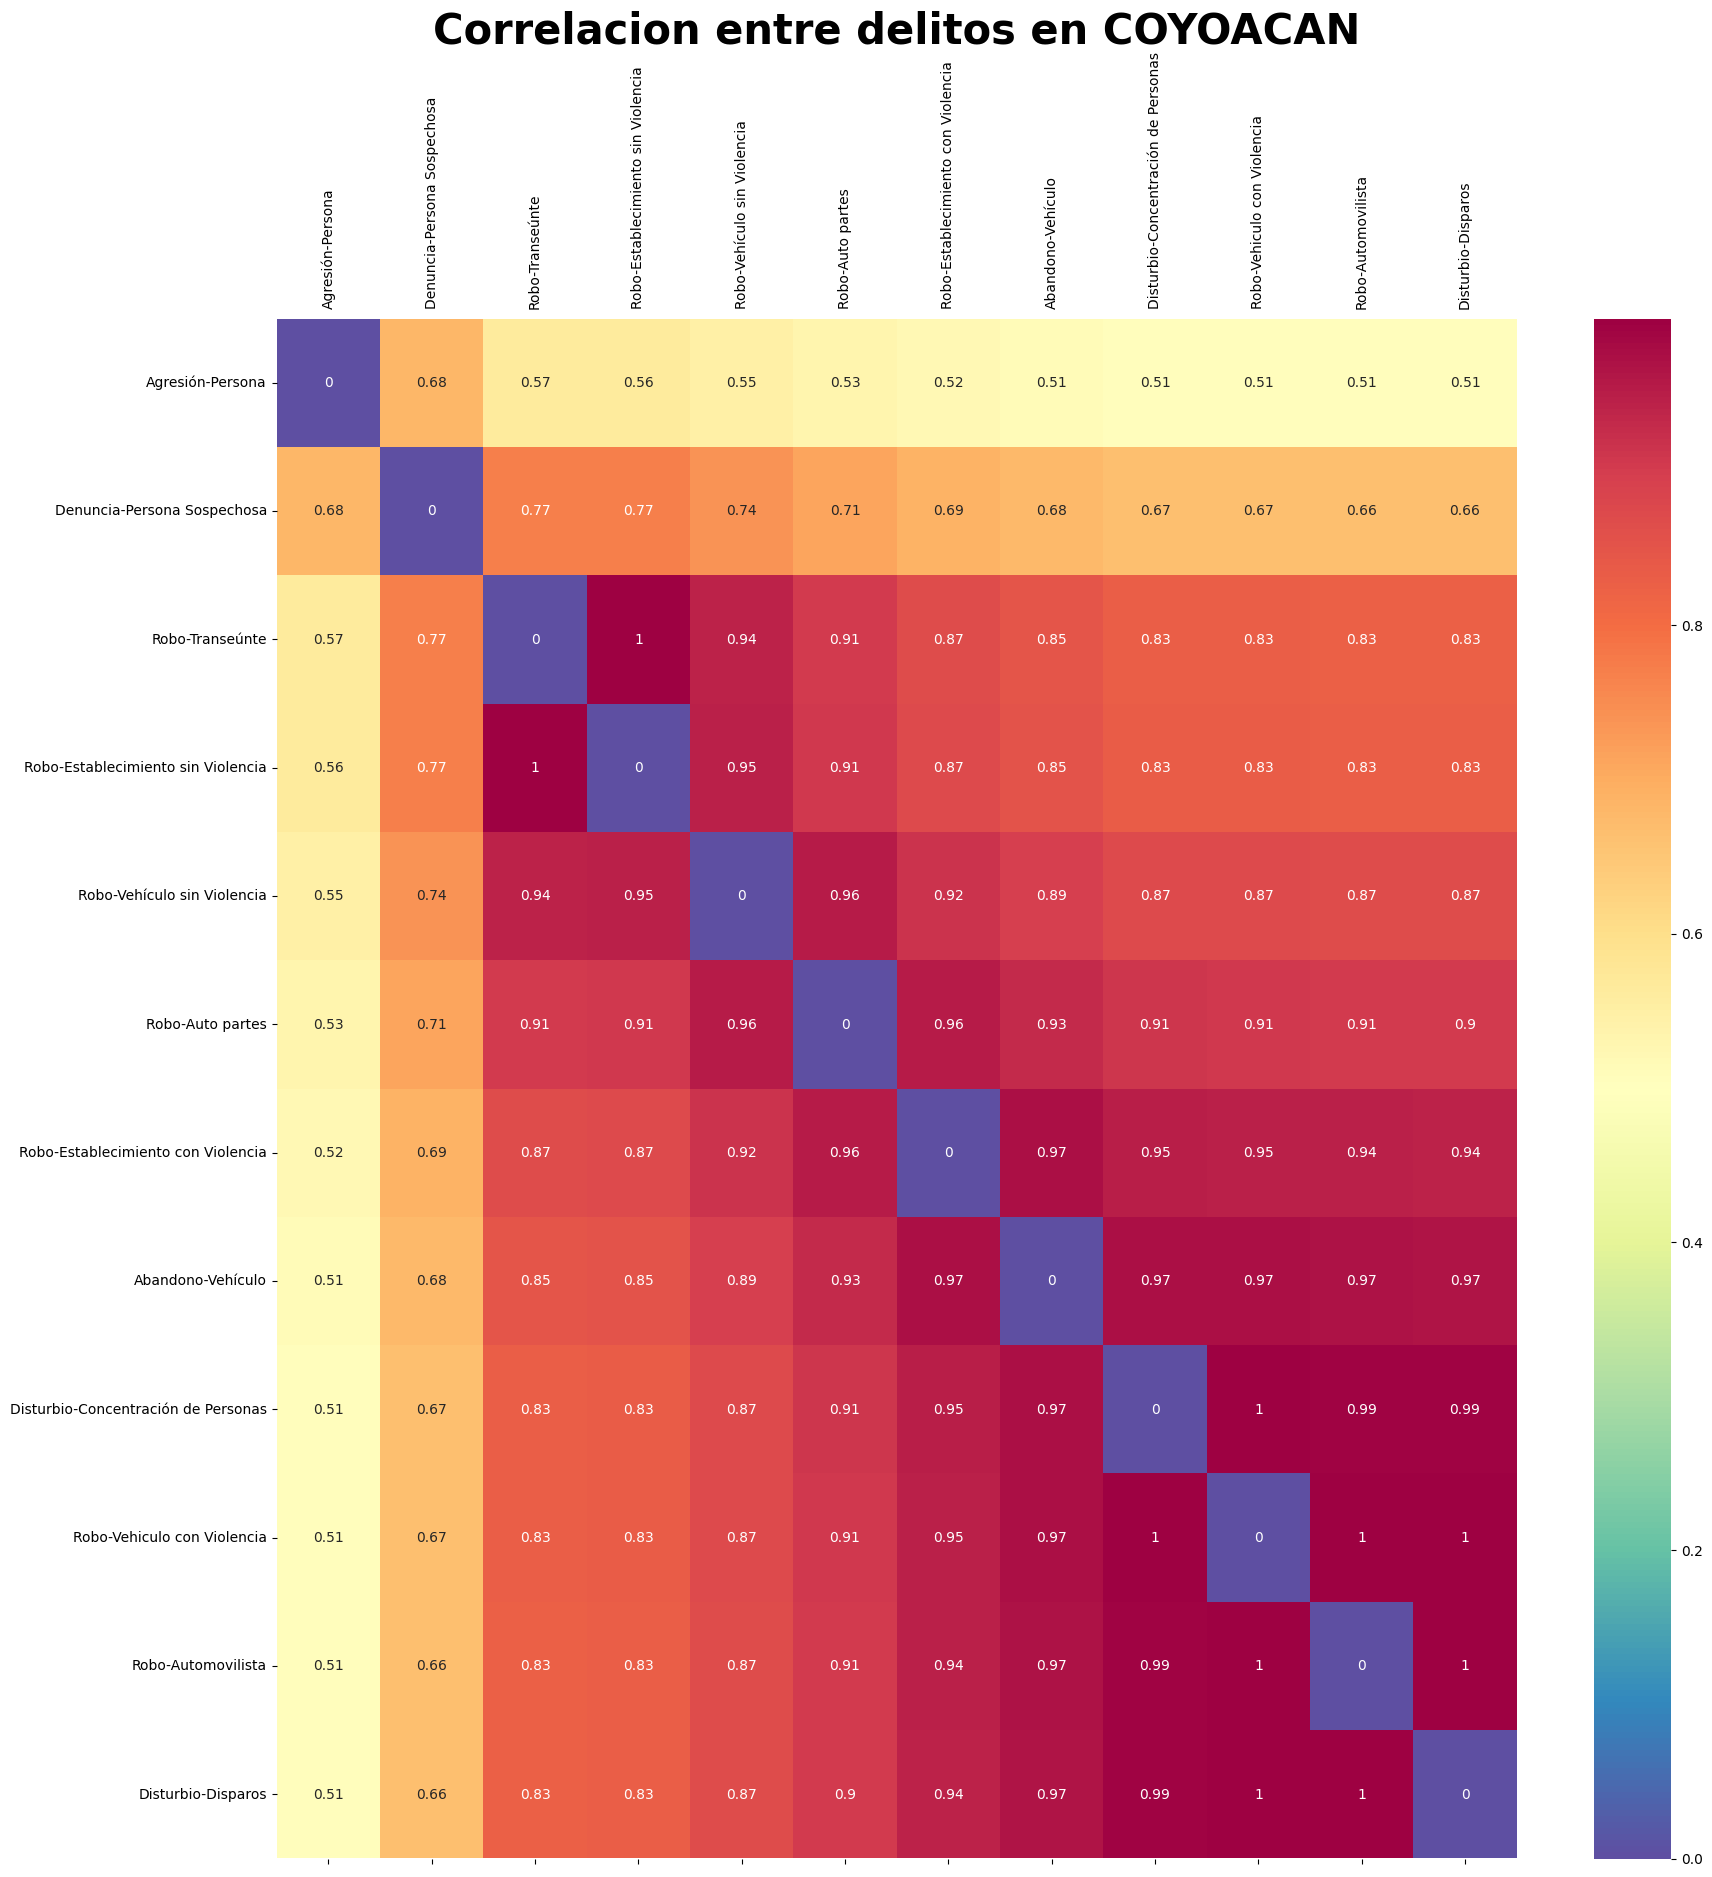

Las 5 relaciones mas fuertes en COYOACAN son:
Robo-Automovilista - Disturbio-Disparos: 0.9991816693944354
Disturbio-Concentración de Personas - Robo-Vehiculo con Violencia: 0.997549019607843
Robo-Transeúnte - Robo-Establecimiento sin Violencia: 0.996734693877551
Robo-Vehiculo con Violencia - Robo-Automovilista: 0.996328029375765
Robo-Vehiculo con Violencia - Disturbio-Disparos: 0.9955156950672647



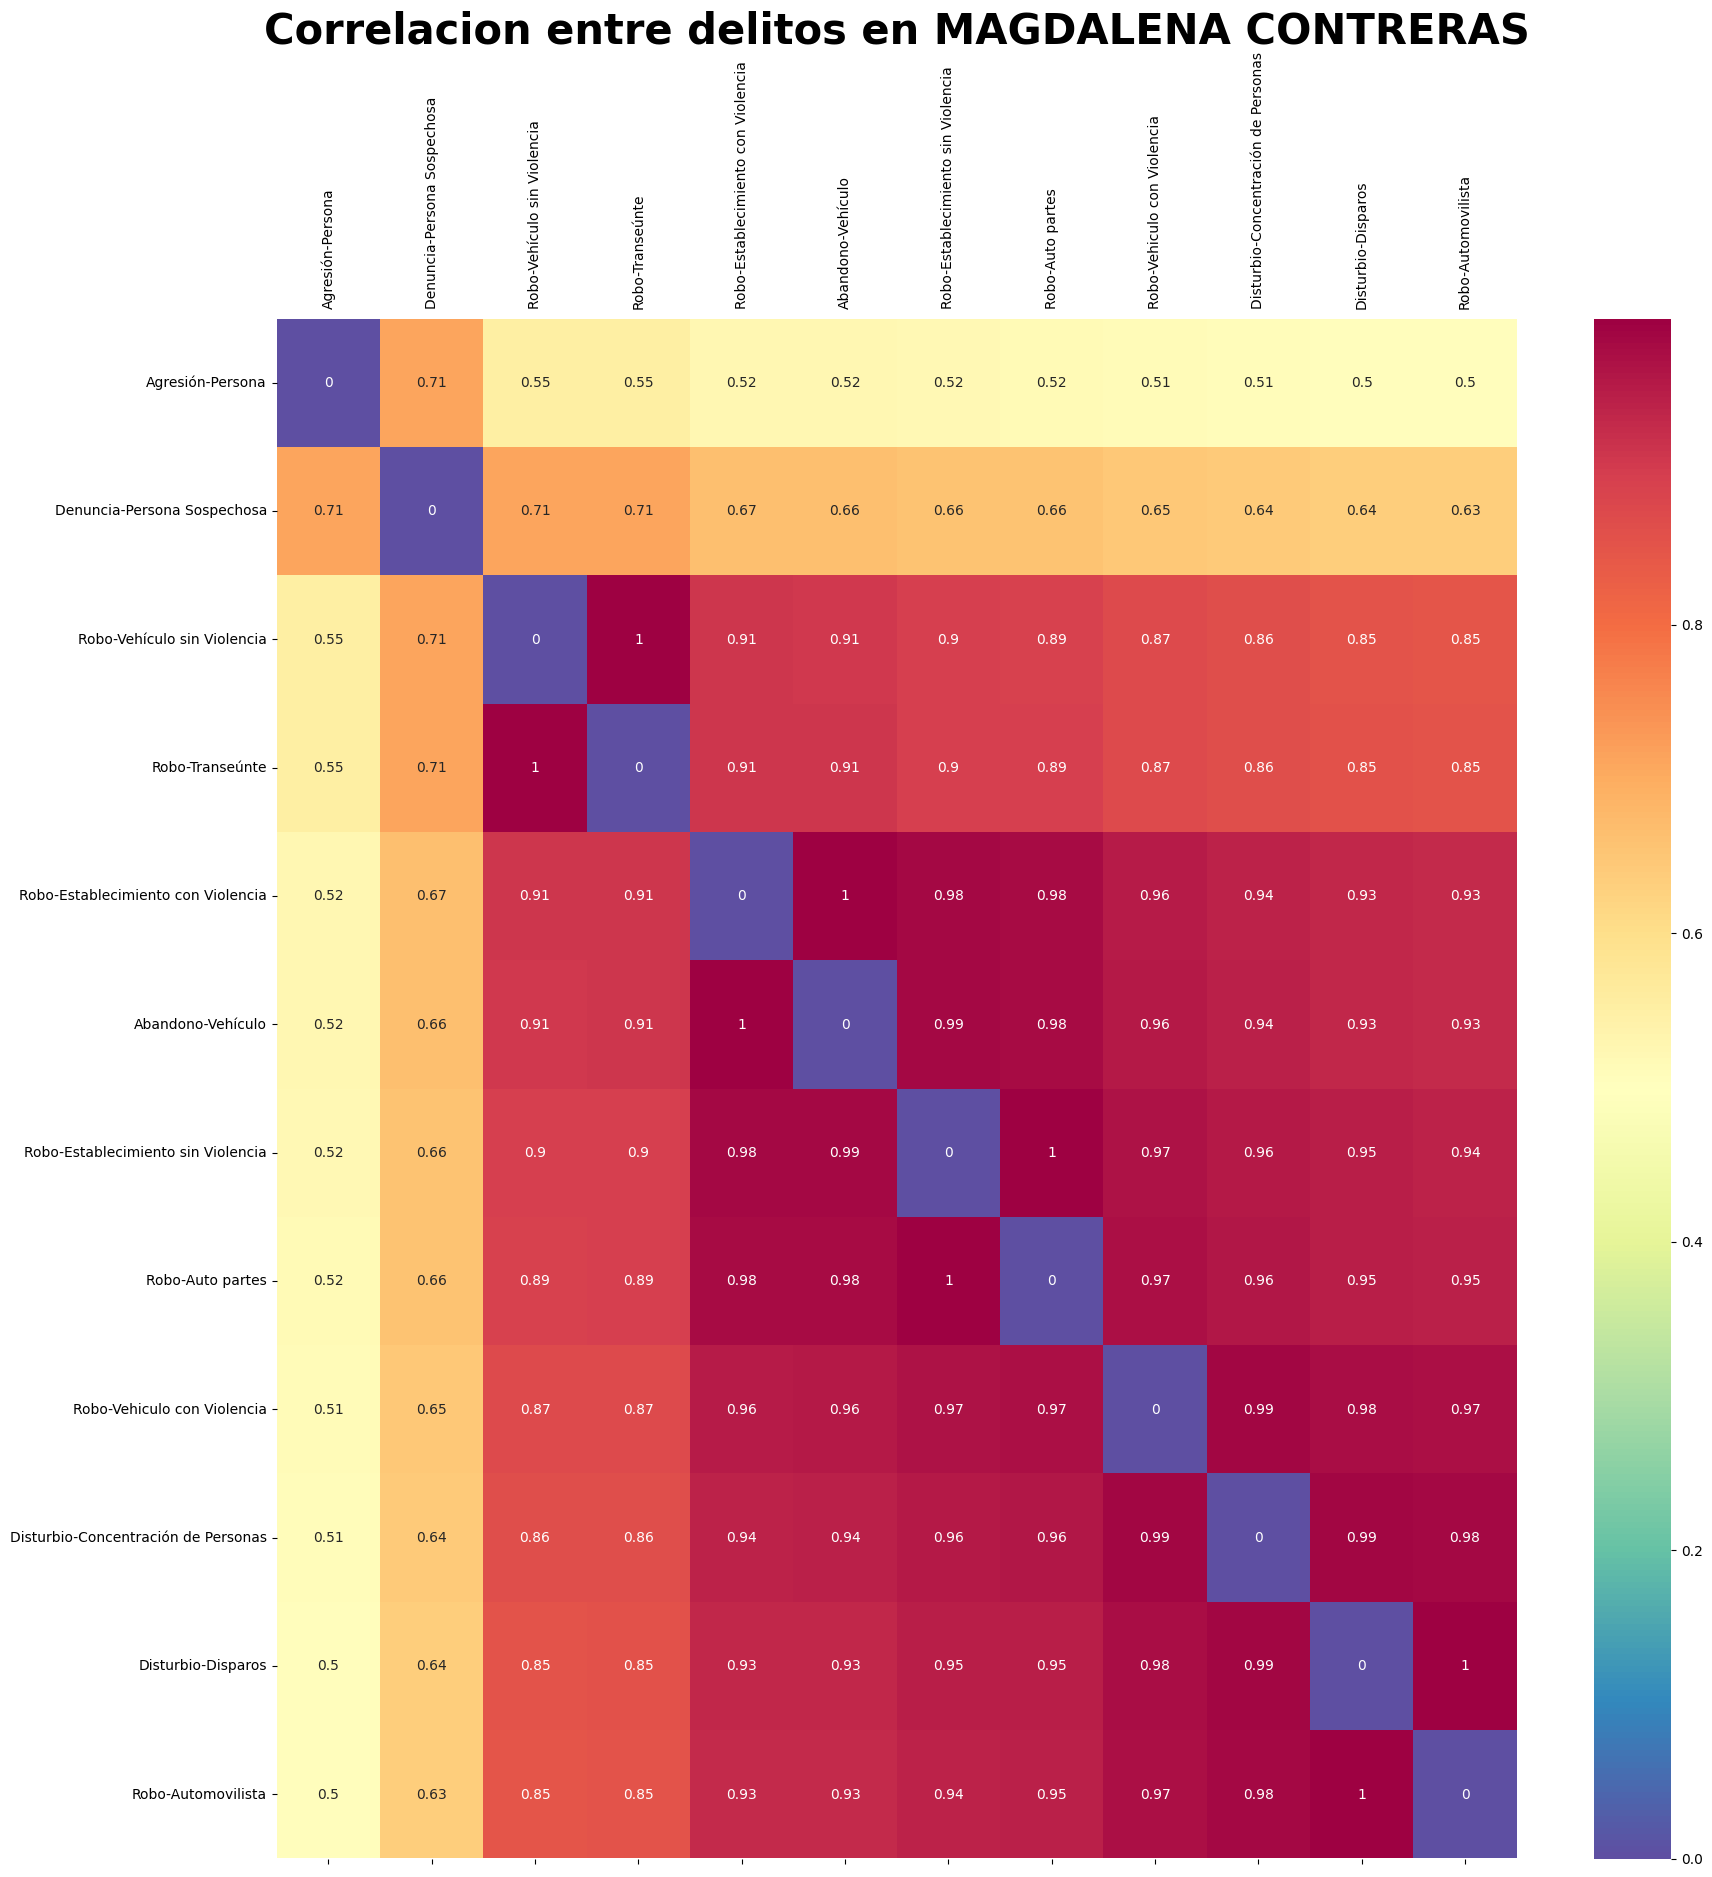

Las 5 relaciones mas fuertes en MAGDALENA CONTRERAS son:
Robo-Vehículo sin Violencia - Robo-Transeúnte: 0.9983844911147012
Robo-Establecimiento con Violencia - Abandono-Vehículo: 0.9983844911147012
Robo-Establecimiento sin Violencia - Robo-Auto partes: 0.996774193548387
Disturbio-Disparos - Robo-Automovilista: 0.9951690821256038
Disturbio-Concentración de Personas - Disturbio-Disparos: 0.9888000000000001



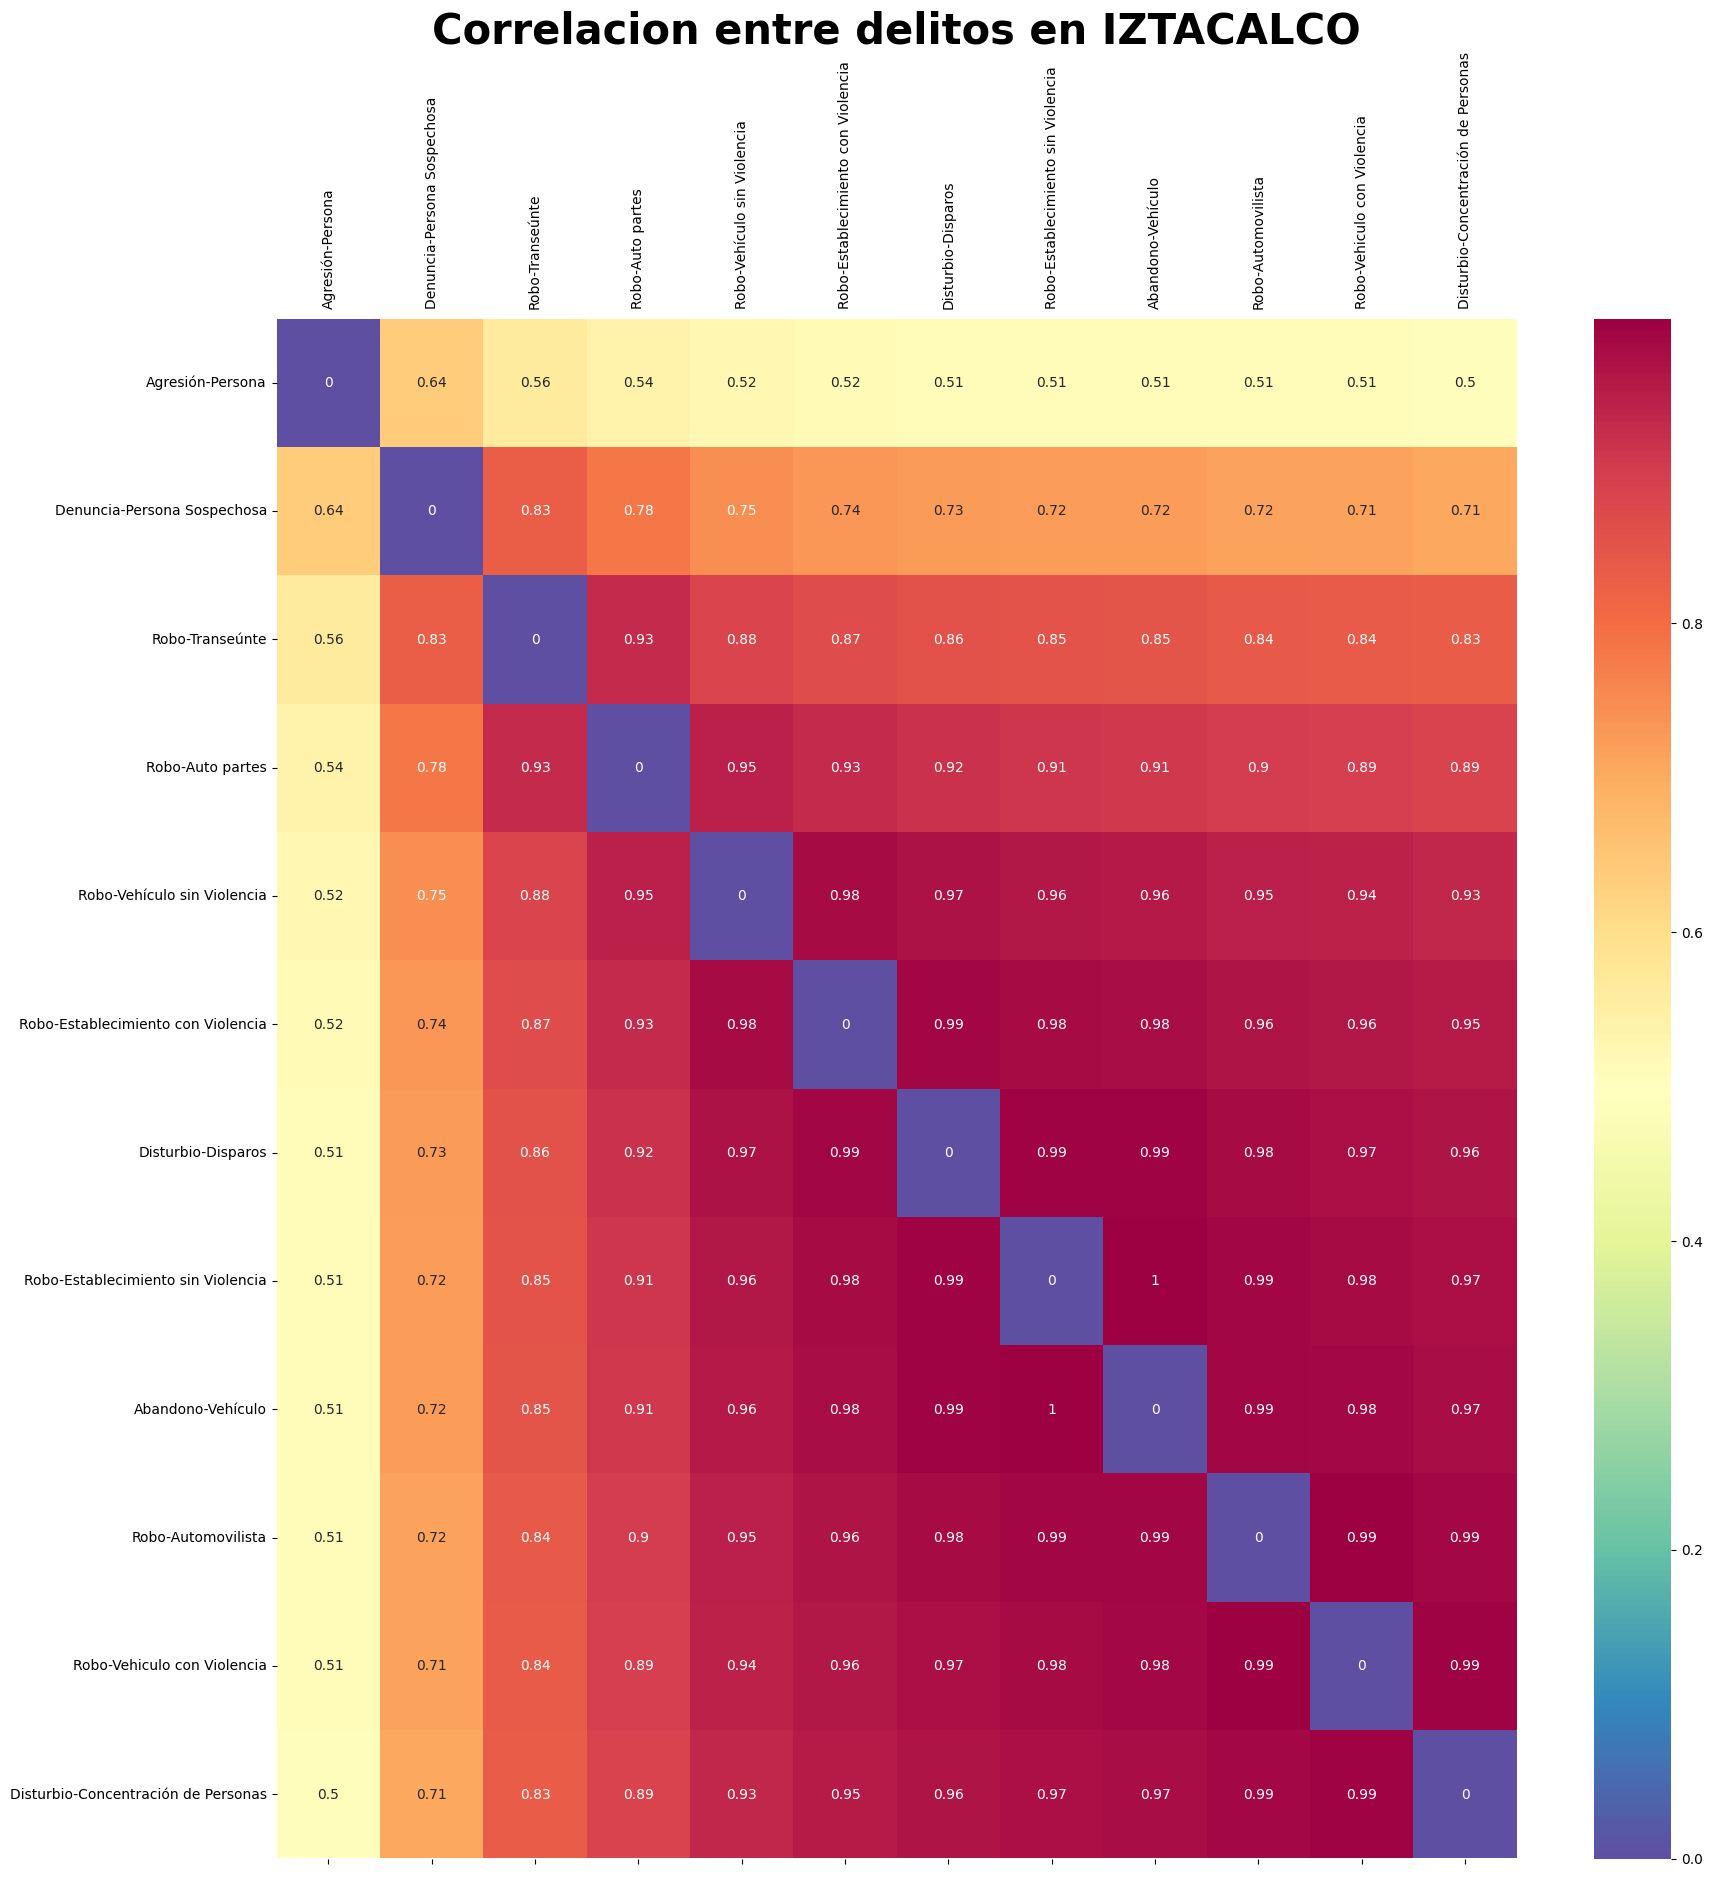

Las 5 relaciones mas fuertes en IZTACALCO son:
Robo-Establecimiento sin Violencia - Abandono-Vehículo: 0.9972920696324952
Robo-Automovilista - Robo-Vehiculo con Violencia: 0.9942151947551099
Disturbio-Disparos - Robo-Establecimiento sin Violencia: 0.9923017705927636
Robo-Vehiculo con Violencia - Disturbio-Concentración de Personas: 0.9911572472126106
Disturbio-Disparos - Abandono-Vehículo: 0.9896353166986563



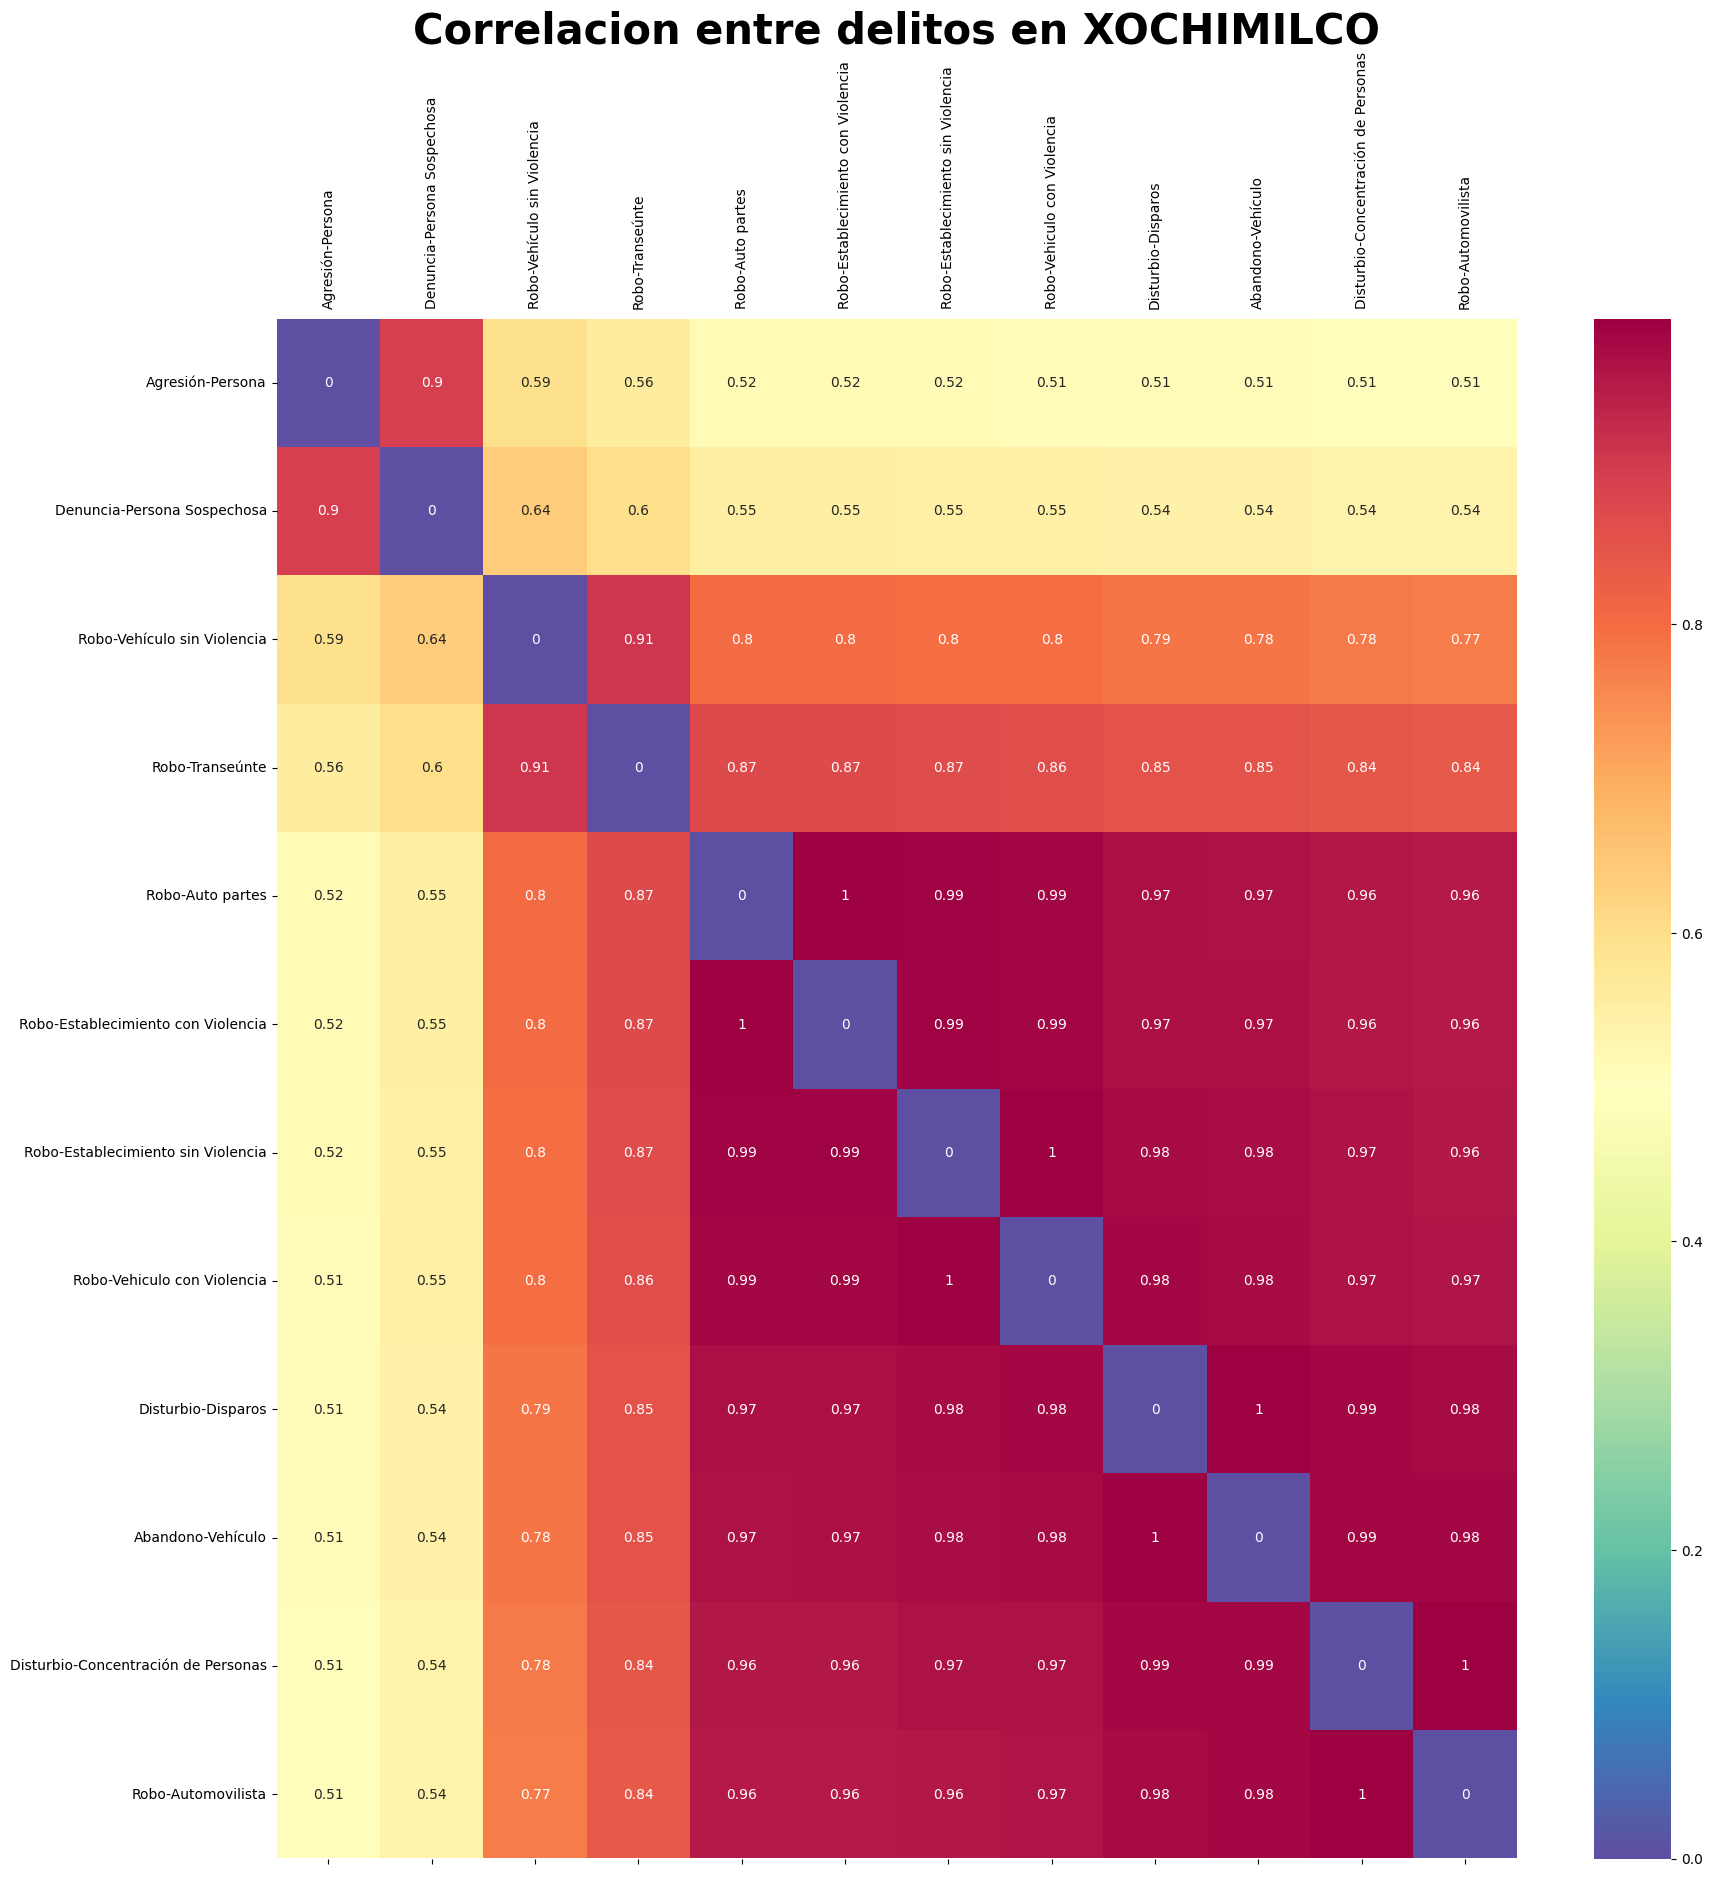

Las 5 relaciones mas fuertes en XOCHIMILCO son:
Robo-Auto partes - Robo-Establecimiento con Violencia: 0.9982206405693951
Disturbio-Disparos - Abandono-Vehículo: 0.9973333333333333
Robo-Establecimiento sin Violencia - Robo-Vehiculo con Violencia: 0.9964476021314387
Disturbio-Concentración de Personas - Robo-Automovilista: 0.9955634427684118
Robo-Establecimiento con Violencia - Robo-Establecimiento sin Violencia: 0.9937998228520813



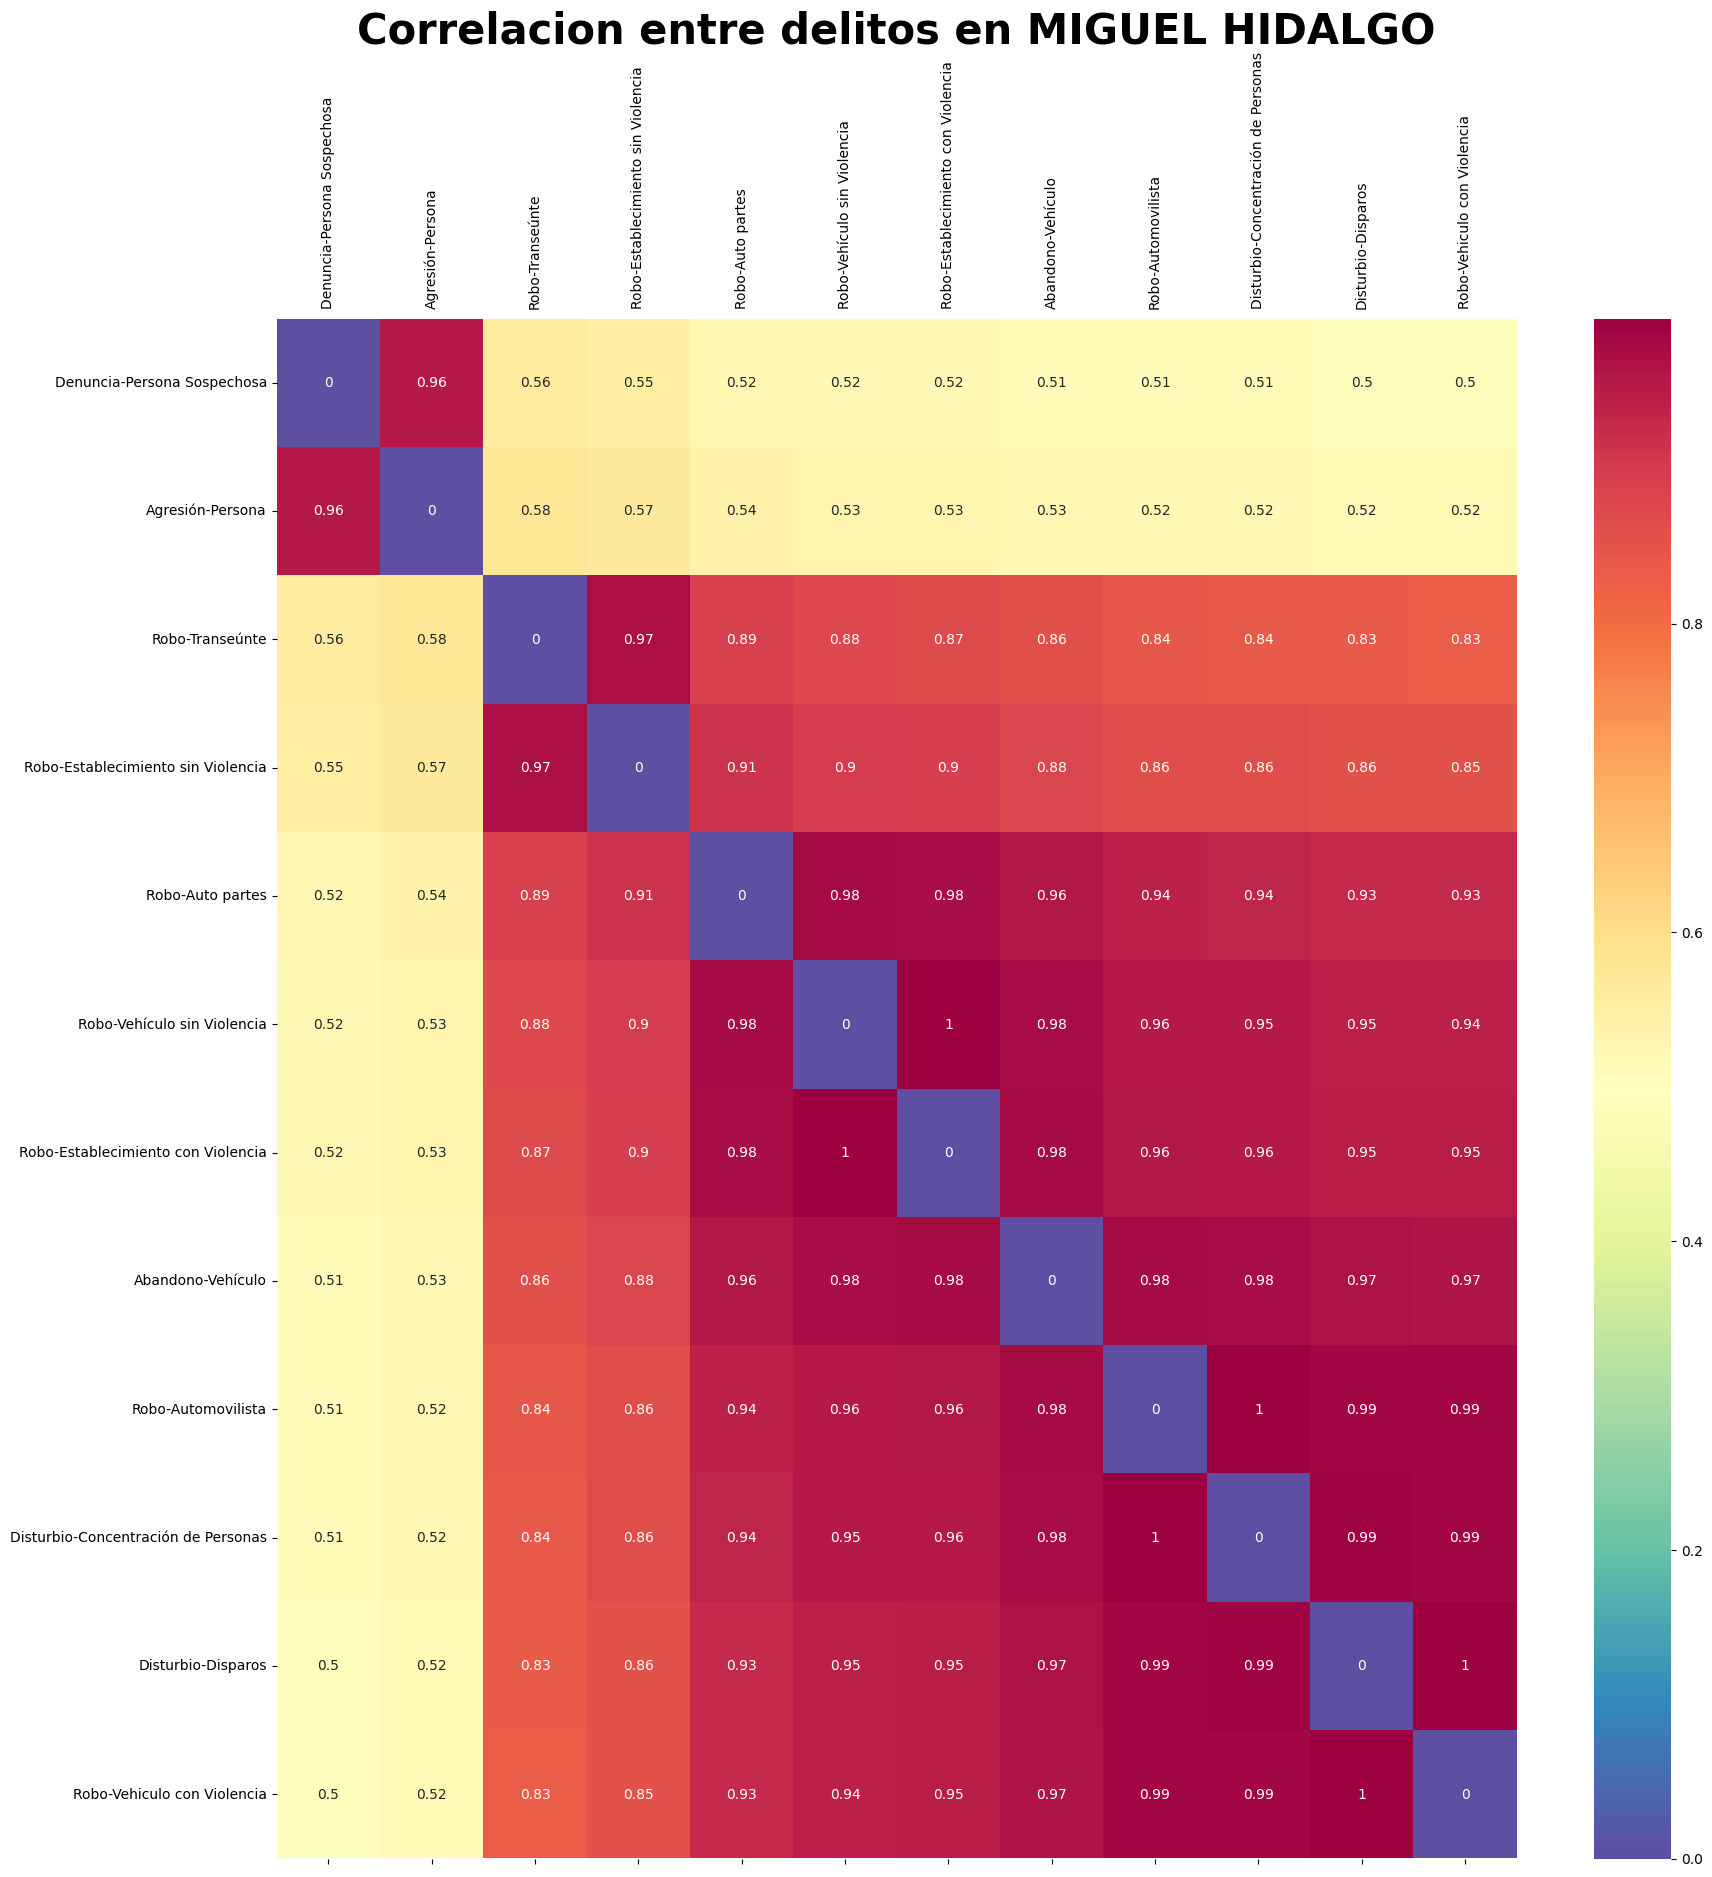

Las 5 relaciones mas fuertes en MIGUEL HIDALGO son:
Robo-Automovilista - Disturbio-Concentración de Personas: 0.9976657329598505
Disturbio-Disparos - Robo-Vehiculo con Violencia: 0.9976657329598505
Robo-Vehículo sin Violencia - Robo-Establecimiento con Violencia: 0.9967350746268656
Disturbio-Concentración de Personas - Disturbio-Disparos: 0.991187384044527
Robo-Automovilista - Disturbio-Disparos: 0.988894030541416



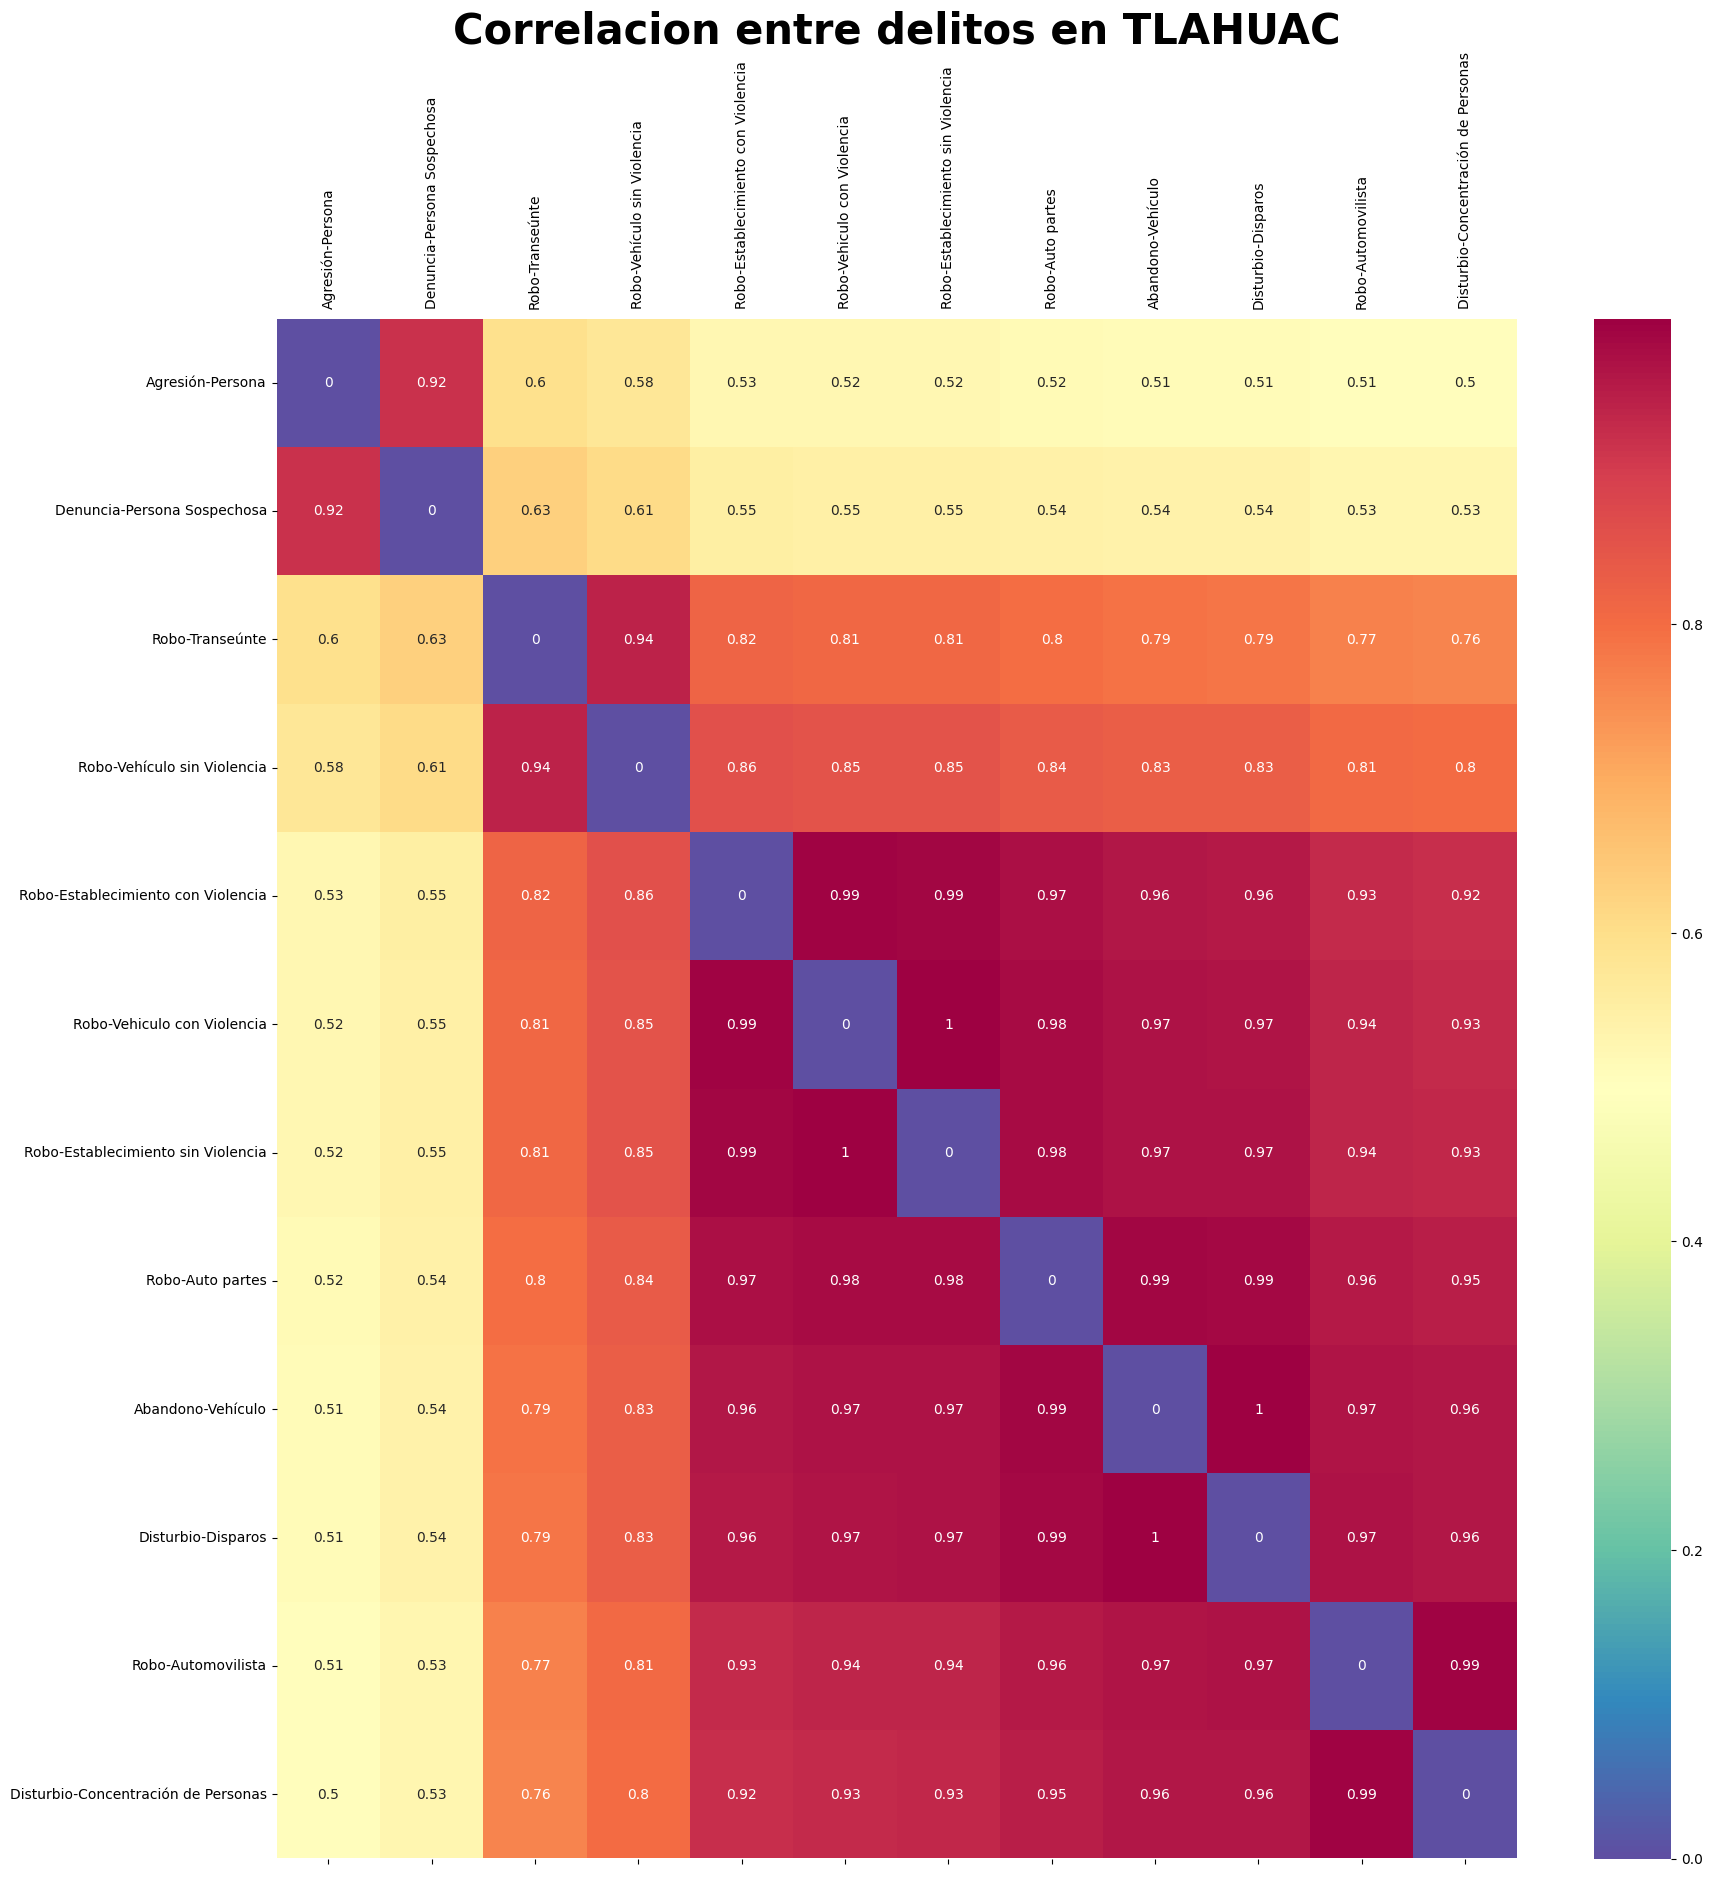

Las 5 relaciones mas fuertes en TLAHUAC son:
Robo-Vehiculo con Violencia - Robo-Establecimiento sin Violencia: 0.9983471074380166
Abandono-Vehículo - Disturbio-Disparos: 0.9975227085053675
Robo-Automovilista - Disturbio-Concentración de Personas: 0.9934210526315789
Robo-Establecimiento con Violencia - Robo-Vehiculo con Violencia: 0.9917898193760263
Robo-Establecimiento con Violencia - Robo-Establecimiento sin Violencia: 0.9901639344262295



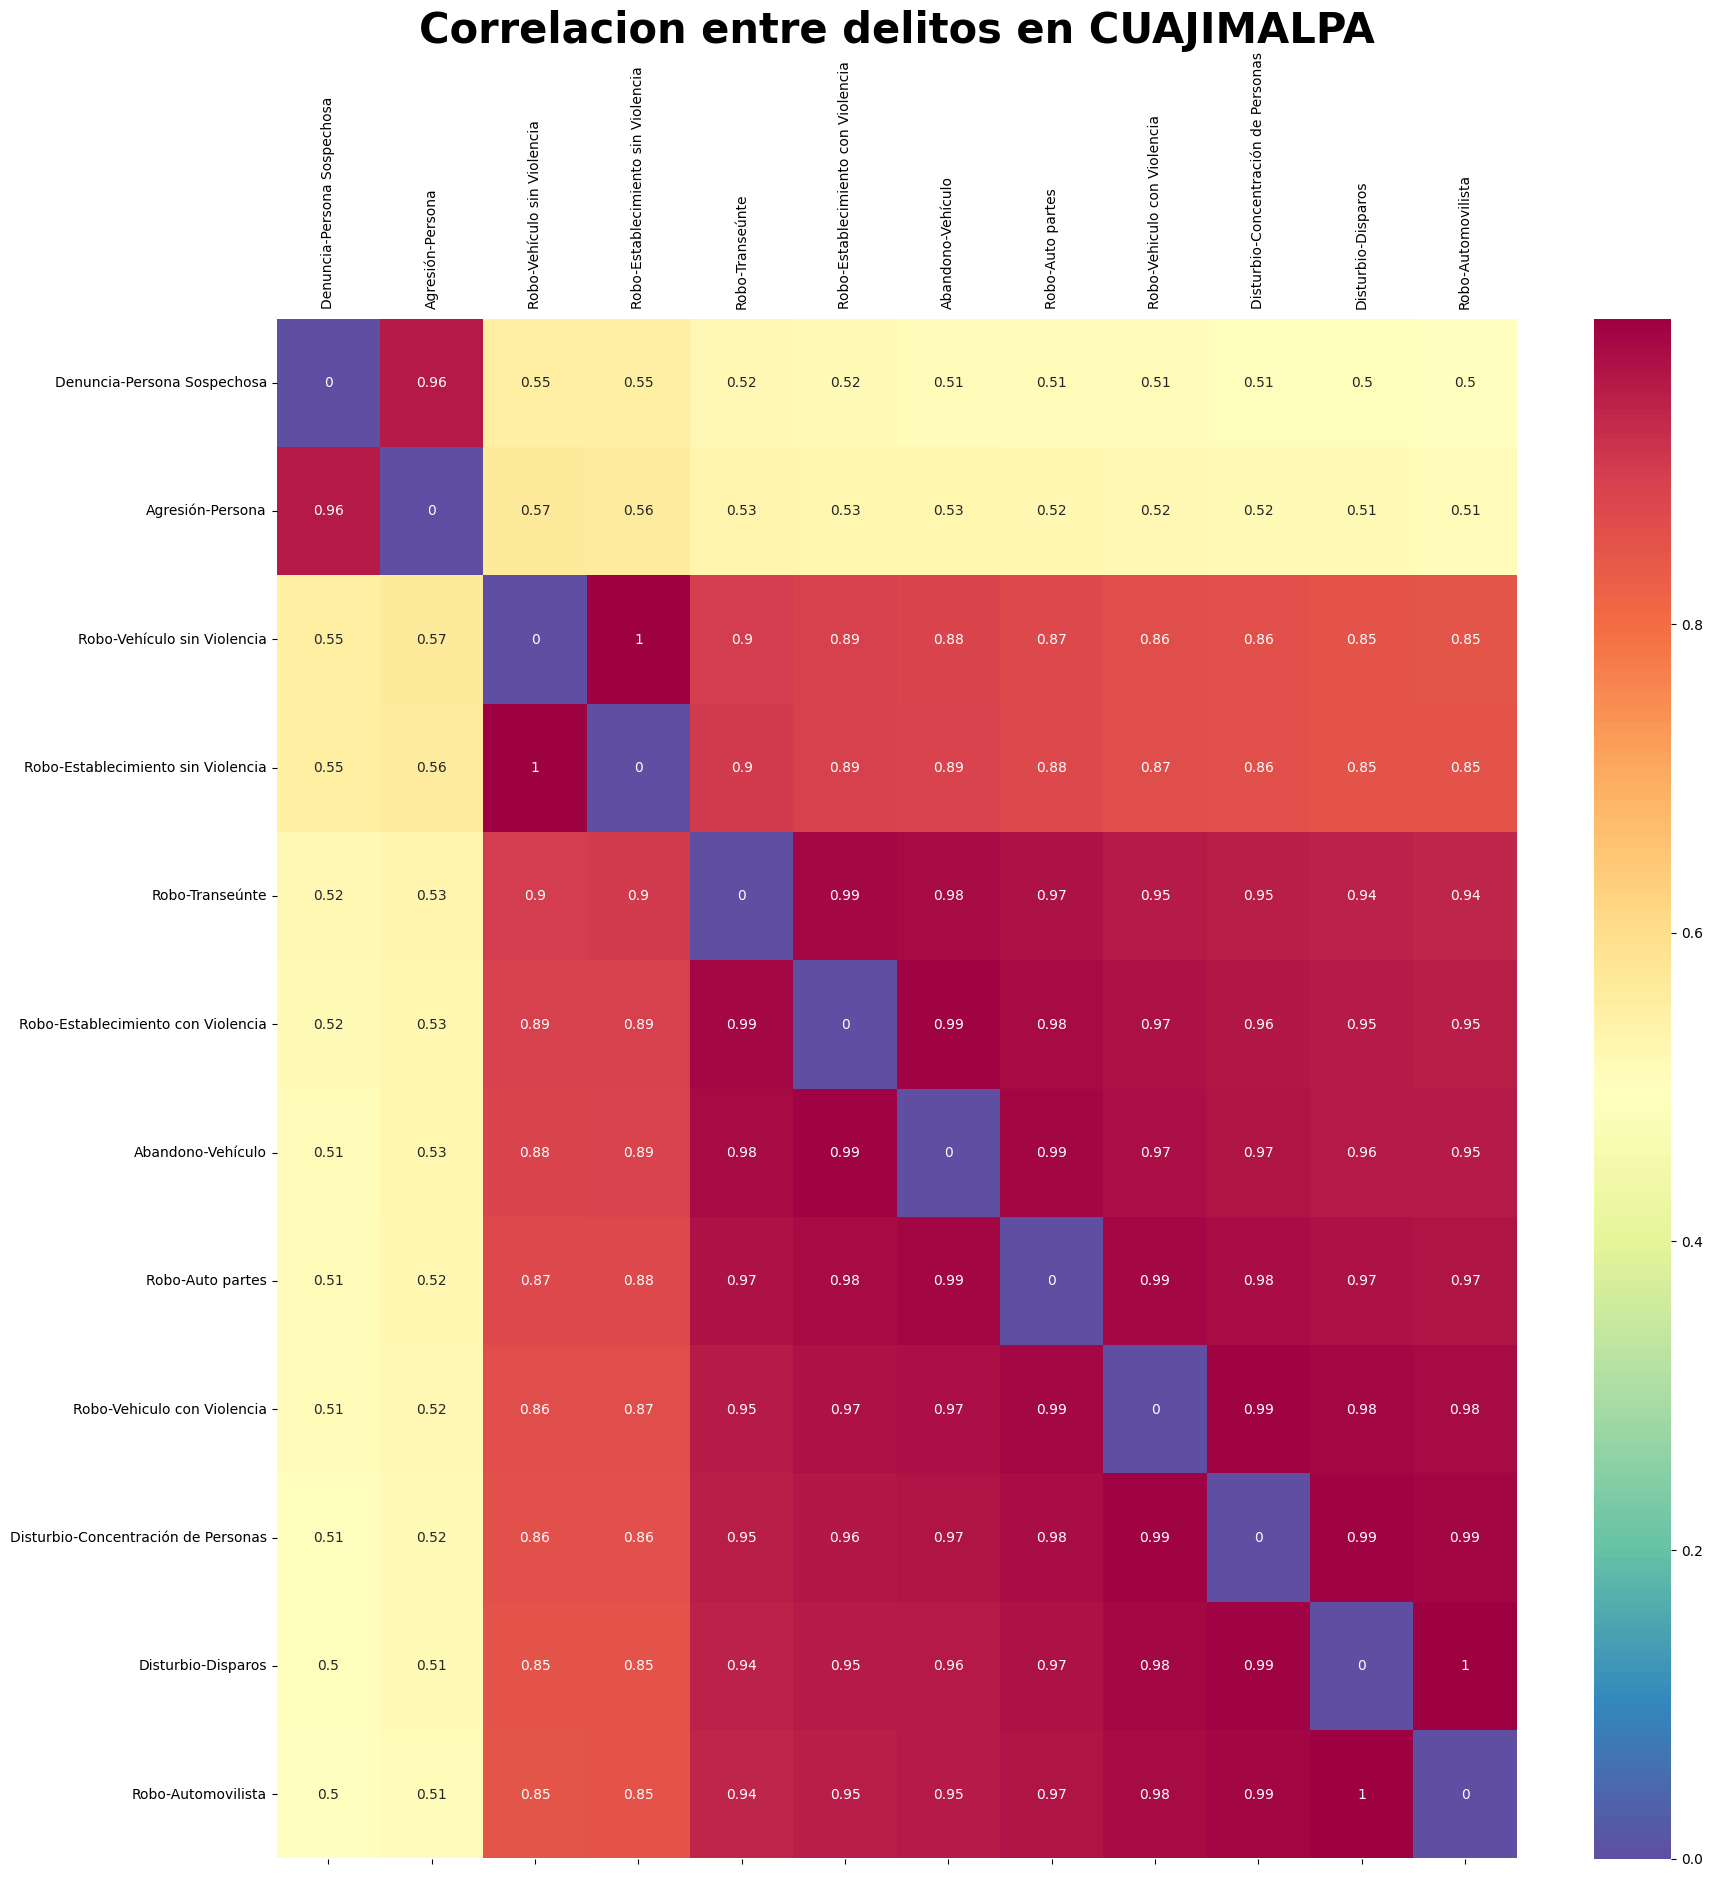

Las 5 relaciones mas fuertes en CUAJIMALPA son:
Robo-Vehículo sin Violencia - Robo-Establecimiento sin Violencia: 0.9979550102249489
Disturbio-Disparos - Robo-Automovilista: 0.9959183673469388
Robo-Establecimiento con Violencia - Abandono-Vehículo: 0.9938900203665989
Robo-Vehiculo con Violencia - Disturbio-Concentración de Personas: 0.9918699186991871
Disturbio-Concentración de Personas - Disturbio-Disparos: 0.9918699186991871



In [48]:
# Correlación de delitos en CDMX por delegacion
import seaborn as sns

# función para crear matriz de correcilación
def matriz_correlacion(delitos_count_norm):
	matriz=[]
	for delito in delitos_count_norm:
		fila=[]
		for delito2 in delitos_count_norm:
			if delito==delito2:
				fila.append(0)
			else:
				fila.append(1/(abs(delito-delito2)+1))
		matriz.append(fila)
	return matriz


df=df.dropna(subset=['delegacion_inicio'])
# print(df['delegacion_inicio'].unique())
for delegacion in df['delegacion_inicio'].unique():
    # filtrar por delegacion
    df_delegacion=df[df['delegacion_inicio']==delegacion]
    # contar los delitos
    delitos_count_norm=df_delegacion['incidente_c4'].value_counts()

    # Normalización de datos, dónde 1 es el valor más alto
    delitos_count_norm=delitos_count_norm/delitos_count_norm.max()

    # crear una matriz de correlacion
    matriz= matriz_correlacion(delitos_count_norm)
    # graficar la matriz en un heatmap con los indices de los delitos
    plt.figure(figsize=(20,20))
    plt.title(f'Correlacion entre delitos en {delegacion}', fontsize=30, fontweight='bold')
    sns.heatmap(matriz, xticklabels=delitos_count_norm.index, yticklabels=delitos_count_norm.index, annot=True, cmap='Spectral_r')
    plt.tick_params(axis='x', labelrotation=90, labeltop=True, labelbottom=False)
    plt.show()

    # Obtener los primeros 5 relaciones mas fuertes
    relaciones = []
    for i in range(len(matriz)):
        for j in range(i,len(matriz[i])):
            if i != j:
                relaciones.append([delitos_count_norm.index[i], delitos_count_norm.index[j], matriz[i][j]])
    relaciones.sort(key=lambda x: x[2], reverse=True)
    print(f'Las 5 relaciones mas fuertes en {delegacion} son:')
    for i in range(5):
        print(f'{relaciones[i][0]} - {relaciones[i][1]}: {relaciones[i][2]}')
    print()
    #creatédirectory correlaciones
    if not os.path.exists('correlaciones'):
        os.makedirs('correlaciones')

    #Save it in excel
    import pandas as pd
    df_cor = pd.DataFrame(relaciones[:5], columns = ['Delito 1', 'Delito 2', 'Correlacion'])
    df_cor.to_excel(f'correlaciones/{delegacion}.xlsx', index=False)

